In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import types

from models.MuseGAN import MuseGAN
from utils.loaders import load_music

from music21 import midi
from music21 import note, stream, duration

In [2]:
# run params
SECTION = 'compose'
RUN_ID = '0005'
DATA_NAME = 'chorales'
FILENAME = 'Jsb16thSeparated.npz'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])



if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))
    os.mkdir(os.path.join(RUN_FOLDER, 'samples'))

mode =  'build' # ' 'load' #

In [3]:
BATCH_SIZE = 64
n_bars = 2
n_steps_per_bar = 16
n_pitches = 84
n_tracks = 4

data_binary, data_ints, raw_data = load_music(DATA_NAME, FILENAME, n_bars, n_steps_per_bar)
data_binary = np.squeeze(data_binary)

In [4]:
gan = MuseGAN(input_dim = data_binary.shape[1:]
        , critic_learning_rate = 0.001
        , generator_learning_rate = 0.001
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 32
        , batch_size = BATCH_SIZE
        , n_tracks = n_tracks
        , n_bars = n_bars
        , n_steps_per_bar = n_steps_per_bar
        , n_pitches = n_pitches
        )

if mode == 'build':
    gan.save(RUN_FOLDER)
else:                 
    gan.load_weights(RUN_FOLDER)

In [5]:
gan.chords_tempNetwork.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
temporal_input (InputLayer)  [(None, 32)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 2, 1, 1024)        66560     
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 1, 1024)        4096      
_________________________________________________________________
activation (Activation)      (None, 2, 1, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 2, 1, 32)          32800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 1, 32)          128 

In [6]:
gan.barGen[0].summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bar_generator_input (InputLa [(None, 128)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              132096    
_________________________________________________________________
batch_normalization_10 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_10 (Activation)   (None, 1024)              0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 2, 1, 512)         0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 4, 1, 512)         524800    
_________________________________________________________________
batch_normalization_11 (Batc (None, 4, 1, 512)         2048

In [7]:
gan.generator.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
melody_input (InputLayer)       [(None, 4, 32)]      0                                            
__________________________________________________________________________________________________
chords_input (InputLayer)       [(None, 32)]         0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 32)           0           melody_input[0][0]               
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 32)           0           melody_input[0][0]               
___________________________________________________________________________________________

__________________________________________________________________________________________________
model_6 (Functional)            (None, 1, 16, 84, 1) 1521921     total_input_bar_0_track_0[0][0]  
                                                                 total_input_bar_1_track_0[0][0]  
__________________________________________________________________________________________________
model_7 (Functional)            (None, 1, 16, 84, 1) 1521921     total_input_bar_0_track_1[0][0]  
                                                                 total_input_bar_1_track_1[0][0]  
__________________________________________________________________________________________________
model_8 (Functional)            (None, 1, 16, 84, 1) 1521921     total_input_bar_0_track_2[0][0]  
                                                                 total_input_bar_1_track_2[0][0]  
__________________________________________________________________________________________________
model_9 (F

In [8]:
gan.critic.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 2, 16, 84, 4)]    0         
_________________________________________________________________
conv3d (Conv3D)              multiple                  1152      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
conv3d_1 (Conv3D)            multiple                  16512     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    multiple                  0         
_________________________________________________________________
conv3d_2 (Conv3D)            multiple                  196736    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    multiple                  0     

In [10]:
EPOCHS = 10000
PRINT_EVERY_N_BATCHES = 100

gan.epoch = 0

In [11]:
%%time
gan.train(     
    data_binary
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
)

0 (5, 1) [D loss: (9.6)(R -0.3, F -0.0, G 1.0)] [G loss: -0.0]


/home/hongbeom/.conda/envs/jktest3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1 (5, 1) [D loss: (-270.6)(R -338.9, F -17.6, G 8.6)] [G loss: -78.2]
2 (5, 1) [D loss: (-339.7)(R -734.8, F 28.9, G 36.6)] [G loss: -183.4]
3 (5, 1) [D loss: (-338.4)(R -556.2, F 28.5, G 18.9)] [G loss: -270.6]
4 (5, 1) [D loss: (-109.4)(R -90.1, F -19.8, G 0.1)] [G loss: -81.1]
5 (5, 1) [D loss: (-301.8)(R -628.3, F 145.3, G 18.1)] [G loss: -575.9]
6 (5, 1) [D loss: (-206.7)(R 3.9, F -267.1, G 5.7)] [G loss: -915.4]
7 (5, 1) [D loss: (-154.2)(R -325.9, F 150.8, G 2.1)] [G loss: -383.5]
8 (5, 1) [D loss: (-140.2)(R -514.3, F 286.2, G 8.8)] [G loss: -491.5]
9 (5, 1) [D loss: (-87.3)(R -382.5, F 259.2, G 3.6)] [G loss: -424.2]
10 (5, 1) [D loss: (-47.0)(R -288.7, F 227.9, G 1.4)] [G loss: -327.4]
11 (5, 1) [D loss: (-20.8)(R -209.6, F 185.2, G 0.4)] [G loss: -237.3]
12 (5, 1) [D loss: (-6.7)(R -143.4, F 136.5, G 0.0)] [G loss: -161.2]
13 (5, 1) [D loss: (-2.7)(R -101.1, F 98.3, G 0.0)] [G loss: -108.9]
14 (5, 1) [D loss: (-29.6)(R -39.1, F 3.4, G 0.6)] [G loss: 633.4]
15 (5, 1) [D loss:

119 (5, 1) [D loss: (-27.4)(R 162.3, F -195.0, G 0.5)] [G loss: 263.7]
120 (5, 1) [D loss: (-22.5)(R 87.6, F -111.1, G 0.1)] [G loss: 124.6]
121 (5, 1) [D loss: (-27.5)(R 212.9, F -248.0, G 0.8)] [G loss: 263.5]
122 (5, 1) [D loss: (-26.9)(R 214.7, F -251.5, G 1.0)] [G loss: 261.0]
123 (5, 1) [D loss: (-26.6)(R 153.8, F -186.8, G 0.6)] [G loss: 216.1]
124 (5, 1) [D loss: (-25.9)(R 202.7, F -236.0, G 0.7)] [G loss: 236.8]
125 (5, 1) [D loss: (-27.1)(R 166.7, F -199.4, G 0.6)] [G loss: 274.3]
126 (5, 1) [D loss: (-28.3)(R 134.9, F -173.6, G 1.1)] [G loss: 188.9]
127 (5, 1) [D loss: (-23.3)(R 98.1, F -123.9, G 0.3)] [G loss: 136.8]
128 (5, 1) [D loss: (-27.8)(R 170.9, F -208.5, G 1.0)] [G loss: 220.3]
129 (5, 1) [D loss: (-26.8)(R 158.9, F -198.4, G 1.3)] [G loss: 193.1]
130 (5, 1) [D loss: (-27.0)(R 197.6, F -234.4, G 1.0)] [G loss: 225.6]
131 (5, 1) [D loss: (-26.9)(R 138.5, F -173.2, G 0.8)] [G loss: 242.2]
132 (5, 1) [D loss: (-20.3)(R 95.2, F -116.0, G 0.1)] [G loss: 140.0]
133 (5, 1

236 (5, 1) [D loss: (-20.3)(R 77.3, F -104.5, G 0.7)] [G loss: 96.4]
237 (5, 1) [D loss: (-21.3)(R 59.4, F -85.8, G 0.5)] [G loss: 110.4]
238 (5, 1) [D loss: (-19.9)(R 104.6, F -127.0, G 0.2)] [G loss: 169.3]
239 (5, 1) [D loss: (-18.3)(R 69.2, F -91.4, G 0.4)] [G loss: 104.2]
240 (5, 1) [D loss: (-19.8)(R 101.7, F -129.9, G 0.8)] [G loss: 101.4]
241 (5, 1) [D loss: (-20.0)(R 71.5, F -95.9, G 0.4)] [G loss: 96.8]
242 (5, 1) [D loss: (-20.2)(R 83.4, F -110.4, G 0.7)] [G loss: 99.8]
243 (5, 1) [D loss: (-18.9)(R 70.4, F -99.2, G 1.0)] [G loss: 57.1]
244 (5, 1) [D loss: (-18.8)(R 53.1, F -75.7, G 0.4)] [G loss: 107.5]
245 (5, 1) [D loss: (-20.0)(R 123.2, F -149.9, G 0.7)] [G loss: 133.9]
246 (5, 1) [D loss: (-20.3)(R 108.5, F -133.4, G 0.5)] [G loss: 150.4]
247 (5, 1) [D loss: (-20.5)(R 103.3, F -135.2, G 1.1)] [G loss: 93.2]
248 (5, 1) [D loss: (-20.7)(R 71.4, F -97.2, G 0.5)] [G loss: 97.4]
249 (5, 1) [D loss: (-21.2)(R 87.9, F -115.2, G 0.6)] [G loss: 117.9]
250 (5, 1) [D loss: (-20.6)

355 (5, 1) [D loss: (-20.5)(R 66.3, F -96.6, G 1.0)] [G loss: 82.0]
356 (5, 1) [D loss: (-21.3)(R 74.8, F -103.6, G 0.7)] [G loss: 101.4]
357 (5, 1) [D loss: (-20.2)(R 46.0, F -69.8, G 0.4)] [G loss: 77.8]
358 (5, 1) [D loss: (-21.8)(R 43.7, F -70.7, G 0.5)] [G loss: 93.8]
359 (5, 1) [D loss: (-21.3)(R 34.3, F -58.4, G 0.3)] [G loss: 68.1]
360 (5, 1) [D loss: (-21.7)(R 56.8, F -85.7, G 0.7)] [G loss: 90.6]
361 (5, 1) [D loss: (-21.3)(R 58.4, F -84.5, G 0.5)] [G loss: 95.9]
362 (5, 1) [D loss: (-19.8)(R 52.3, F -73.4, G 0.1)] [G loss: 88.5]
363 (5, 1) [D loss: (-20.7)(R 43.7, F -70.2, G 0.6)] [G loss: 74.9]
364 (5, 1) [D loss: (-21.9)(R 31.8, F -59.8, G 0.6)] [G loss: 56.1]
365 (5, 1) [D loss: (-20.4)(R 97.0, F -126.7, G 0.9)] [G loss: 135.2]
366 (5, 1) [D loss: (-21.0)(R 131.2, F -158.4, G 0.6)] [G loss: 174.3]
367 (5, 1) [D loss: (-19.6)(R 102.9, F -131.0, G 0.8)] [G loss: 104.9]
368 (5, 1) [D loss: (-20.5)(R 72.2, F -96.4, G 0.4)] [G loss: 110.0]
369 (5, 1) [D loss: (-21.8)(R 75.8, F

476 (5, 1) [D loss: (-22.9)(R 32.8, F -63.1, G 0.7)] [G loss: 64.0]
477 (5, 1) [D loss: (-22.5)(R 43.5, F -73.8, G 0.8)] [G loss: 72.1]
478 (5, 1) [D loss: (-21.1)(R 19.5, F -44.3, G 0.4)] [G loss: 54.2]
479 (5, 1) [D loss: (-21.5)(R 46.6, F -77.7, G 1.0)] [G loss: 64.0]
480 (5, 1) [D loss: (-21.6)(R 42.7, F -68.9, G 0.5)] [G loss: 85.0]
481 (5, 1) [D loss: (-21.3)(R 36.4, F -66.4, G 0.9)] [G loss: 62.9]
482 (5, 1) [D loss: (-22.7)(R 32.0, F -60.5, G 0.6)] [G loss: 72.2]
483 (5, 1) [D loss: (-22.0)(R 40.7, F -68.8, G 0.6)] [G loss: 70.0]
484 (5, 1) [D loss: (-21.4)(R 37.7, F -64.4, G 0.5)] [G loss: 72.6]
485 (5, 1) [D loss: (-21.2)(R 58.7, F -89.2, G 0.9)] [G loss: 71.8]
486 (5, 1) [D loss: (-22.1)(R 29.7, F -57.2, G 0.5)] [G loss: 67.0]
487 (5, 1) [D loss: (-20.9)(R 29.2, F -52.9, G 0.3)] [G loss: 50.7]
488 (5, 1) [D loss: (-21.9)(R 70.7, F -101.1, G 0.9)] [G loss: 103.3]
489 (5, 1) [D loss: (-21.6)(R 52.1, F -78.0, G 0.4)] [G loss: 81.0]
490 (5, 1) [D loss: (-22.4)(R 45.6, F -73.3, G

597 (5, 1) [D loss: (-22.8)(R 42.3, F -70.6, G 0.6)] [G loss: 77.5]
598 (5, 1) [D loss: (-22.7)(R 33.9, F -67.0, G 1.0)] [G loss: 51.7]
599 (5, 1) [D loss: (-22.8)(R 34.9, F -63.2, G 0.6)] [G loss: 68.6]
600 (5, 1) [D loss: (-23.0)(R 37.5, F -73.1, G 1.3)] [G loss: 50.0]
601 (5, 1) [D loss: (-23.8)(R 32.0, F -64.4, G 0.9)] [G loss: 67.7]
602 (5, 1) [D loss: (-22.3)(R 55.2, F -89.5, G 1.2)] [G loss: 56.0]
603 (5, 1) [D loss: (-22.5)(R 35.5, F -69.0, G 1.1)] [G loss: 55.1]
604 (5, 1) [D loss: (-23.6)(R 20.3, F -49.6, G 0.6)] [G loss: 58.6]
605 (5, 1) [D loss: (-22.7)(R 25.0, F -53.9, G 0.6)] [G loss: 58.3]
606 (5, 1) [D loss: (-22.2)(R 37.9, F -64.6, G 0.5)] [G loss: 64.8]
607 (5, 1) [D loss: (-23.4)(R 37.1, F -67.0, G 0.7)] [G loss: 71.5]
608 (5, 1) [D loss: (-23.0)(R 28.6, F -58.4, G 0.7)] [G loss: 50.8]
609 (5, 1) [D loss: (-22.3)(R 43.1, F -71.4, G 0.6)] [G loss: 89.7]
610 (5, 1) [D loss: (-23.3)(R 14.1, F -43.5, G 0.6)] [G loss: 78.1]
611 (5, 1) [D loss: (-23.6)(R 45.7, F -74.2, G 0

718 (5, 1) [D loss: (-24.2)(R 20.2, F -53.1, G 0.9)] [G loss: 52.9]
719 (5, 1) [D loss: (-23.3)(R 14.6, F -44.8, G 0.7)] [G loss: 51.2]
720 (5, 1) [D loss: (-23.4)(R 17.0, F -54.0, G 1.4)] [G loss: 22.9]
721 (5, 1) [D loss: (-22.2)(R 80.3, F -105.7, G 0.3)] [G loss: 110.8]
722 (5, 1) [D loss: (-23.3)(R 65.1, F -95.8, G 0.7)] [G loss: 94.0]
723 (5, 1) [D loss: (-23.6)(R 48.4, F -76.2, G 0.4)] [G loss: 86.7]
724 (5, 1) [D loss: (-23.3)(R 54.8, F -87.7, G 1.0)] [G loss: 81.3]
725 (5, 1) [D loss: (-23.6)(R 48.5, F -79.7, G 0.8)] [G loss: 80.5]
726 (5, 1) [D loss: (-23.4)(R 47.3, F -79.7, G 0.9)] [G loss: 71.8]
727 (5, 1) [D loss: (-22.8)(R 43.8, F -75.4, G 0.9)] [G loss: 71.4]
728 (5, 1) [D loss: (-22.9)(R 39.9, F -66.6, G 0.4)] [G loss: 70.5]
729 (5, 1) [D loss: (-23.3)(R 48.3, F -77.7, G 0.6)] [G loss: 80.1]
730 (5, 1) [D loss: (-23.5)(R 32.5, F -62.1, G 0.6)] [G loss: 63.6]
731 (5, 1) [D loss: (-23.5)(R 29.7, F -61.5, G 0.8)] [G loss: 59.1]
732 (5, 1) [D loss: (-23.6)(R 29.9, F -61.4, G

839 (5, 1) [D loss: (-23.4)(R 13.5, F -46.6, G 1.0)] [G loss: 38.0]
840 (5, 1) [D loss: (-23.5)(R 17.5, F -46.2, G 0.5)] [G loss: 53.8]
841 (5, 1) [D loss: (-23.8)(R 24.7, F -56.5, G 0.8)] [G loss: 56.9]
842 (5, 1) [D loss: (-23.4)(R 16.1, F -46.5, G 0.7)] [G loss: 49.2]
843 (5, 1) [D loss: (-24.2)(R 17.4, F -47.6, G 0.6)] [G loss: 56.5]
844 (5, 1) [D loss: (-23.2)(R 15.8, F -48.4, G 0.9)] [G loss: 34.9]
845 (5, 1) [D loss: (-23.6)(R 33.5, F -65.0, G 0.8)] [G loss: 64.3]
846 (5, 1) [D loss: (-23.3)(R 30.6, F -66.9, G 1.3)] [G loss: 47.6]
847 (5, 1) [D loss: (-23.0)(R 19.6, F -53.8, G 1.1)] [G loss: 47.3]
848 (5, 1) [D loss: (-23.8)(R 20.4, F -51.2, G 0.7)] [G loss: 54.2]
849 (5, 1) [D loss: (-22.8)(R 20.1, F -46.5, G 0.4)] [G loss: 46.4]
850 (5, 1) [D loss: (-24.9)(R 18.1, F -50.7, G 0.8)] [G loss: 51.0]
851 (5, 1) [D loss: (-24.0)(R 17.6, F -53.3, G 1.2)] [G loss: 49.3]
852 (5, 1) [D loss: (-23.4)(R 13.7, F -41.8, G 0.5)] [G loss: 51.7]
853 (5, 1) [D loss: (-23.8)(R 30.8, F -64.2, G 1

960 (5, 1) [D loss: (-23.7)(R 12.8, F -44.0, G 0.7)] [G loss: 43.6]
961 (5, 1) [D loss: (-24.2)(R 12.7, F -47.5, G 1.1)] [G loss: 44.1]
962 (5, 1) [D loss: (-24.3)(R 15.5, F -48.4, G 0.9)] [G loss: 41.5]
963 (5, 1) [D loss: (-22.9)(R 12.4, F -47.2, G 1.2)] [G loss: 37.8]
964 (5, 1) [D loss: (-24.2)(R 6.8, F -36.6, G 0.6)] [G loss: 44.9]
965 (5, 1) [D loss: (-23.7)(R 12.3, F -41.9, G 0.6)] [G loss: 46.5]
966 (5, 1) [D loss: (-24.1)(R 44.1, F -77.9, G 1.0)] [G loss: 75.4]
967 (5, 1) [D loss: (-24.6)(R 43.3, F -77.8, G 1.0)] [G loss: 71.9]
968 (5, 1) [D loss: (-23.4)(R 35.1, F -72.6, G 1.4)] [G loss: 57.9]
969 (5, 1) [D loss: (-24.0)(R 22.5, F -54.2, G 0.8)] [G loss: 53.9]
970 (5, 1) [D loss: (-22.8)(R 17.8, F -52.4, G 1.2)] [G loss: 46.3]
971 (5, 1) [D loss: (-23.7)(R 9.7, F -39.4, G 0.6)] [G loss: 41.5]
972 (5, 1) [D loss: (-23.5)(R 20.0, F -48.1, G 0.5)] [G loss: 54.8]
973 (5, 1) [D loss: (-24.0)(R 20.7, F -51.1, G 0.6)] [G loss: 55.4]
974 (5, 1) [D loss: (-24.2)(R 20.0, F -52.1, G 0.8

1080 (5, 1) [D loss: (-23.9)(R 12.3, F -43.0, G 0.7)] [G loss: 43.1]
1081 (5, 1) [D loss: (-24.3)(R 9.6, F -43.7, G 1.0)] [G loss: 39.0]
1082 (5, 1) [D loss: (-24.0)(R 15.1, F -46.5, G 0.7)] [G loss: 49.4]
1083 (5, 1) [D loss: (-23.3)(R 19.2, F -45.8, G 0.3)] [G loss: 61.6]
1084 (5, 1) [D loss: (-24.2)(R 11.6, F -40.0, G 0.4)] [G loss: 51.8]
1085 (5, 1) [D loss: (-23.5)(R 14.9, F -49.7, G 1.1)] [G loss: 43.7]
1086 (5, 1) [D loss: (-25.5)(R 16.7, F -50.3, G 0.8)] [G loss: 51.3]
1087 (5, 1) [D loss: (-25.0)(R 11.1, F -43.8, G 0.8)] [G loss: 42.7]
1088 (5, 1) [D loss: (-24.5)(R 12.1, F -41.4, G 0.5)] [G loss: 49.4]
1089 (5, 1) [D loss: (-23.9)(R 17.2, F -48.5, G 0.7)] [G loss: 48.9]
1090 (5, 1) [D loss: (-25.0)(R 12.4, F -48.4, G 1.1)] [G loss: 45.1]
1091 (5, 1) [D loss: (-23.7)(R 19.8, F -51.0, G 0.8)] [G loss: 53.5]
1092 (5, 1) [D loss: (-24.2)(R 12.0, F -40.2, G 0.4)] [G loss: 46.4]
1093 (5, 1) [D loss: (-24.3)(R 13.6, F -44.4, G 0.7)] [G loss: 43.2]
1094 (5, 1) [D loss: (-24.0)(R 13.5

1199 (5, 1) [D loss: (-23.5)(R 13.0, F -49.8, G 1.3)] [G loss: 40.1]
1200 (5, 1) [D loss: (-24.3)(R 9.9, F -40.0, G 0.6)] [G loss: 44.4]
1201 (5, 1) [D loss: (-23.5)(R 15.9, F -52.7, G 1.3)] [G loss: 39.1]
1202 (5, 1) [D loss: (-24.8)(R 10.5, F -40.7, G 0.5)] [G loss: 46.3]
1203 (5, 1) [D loss: (-24.8)(R 14.4, F -48.2, G 0.9)] [G loss: 43.9]
1204 (5, 1) [D loss: (-24.7)(R 9.6, F -43.0, G 0.9)] [G loss: 41.6]
1205 (5, 1) [D loss: (-25.5)(R 12.3, F -47.8, G 1.0)] [G loss: 43.3]
1206 (5, 1) [D loss: (-24.5)(R 12.8, F -45.1, G 0.8)] [G loss: 47.9]
1207 (5, 1) [D loss: (-24.6)(R 9.7, F -42.7, G 0.8)] [G loss: 40.5]
1208 (5, 1) [D loss: (-24.5)(R 8.6, F -41.1, G 0.8)] [G loss: 40.9]
1209 (5, 1) [D loss: (-25.0)(R 11.4, F -43.1, G 0.7)] [G loss: 46.4]
1210 (5, 1) [D loss: (-25.0)(R 15.1, F -48.5, G 0.8)] [G loss: 43.2]
1211 (5, 1) [D loss: (-25.2)(R 12.1, F -44.5, G 0.7)] [G loss: 49.8]
1212 (5, 1) [D loss: (-24.5)(R 10.8, F -44.3, G 0.9)] [G loss: 45.5]
1213 (5, 1) [D loss: (-24.7)(R 7.9, F 

1319 (5, 1) [D loss: (-25.5)(R 9.1, F -42.7, G 0.8)] [G loss: 45.0]
1320 (5, 1) [D loss: (-24.8)(R 9.9, F -40.1, G 0.5)] [G loss: 41.7]
1321 (5, 1) [D loss: (-24.4)(R 12.0, F -45.0, G 0.9)] [G loss: 41.1]
1322 (5, 1) [D loss: (-25.0)(R 12.0, F -47.7, G 1.1)] [G loss: 43.2]
1323 (5, 1) [D loss: (-23.9)(R 8.7, F -40.7, G 0.8)] [G loss: 36.3]
1324 (5, 1) [D loss: (-25.1)(R 12.4, F -48.8, G 1.1)] [G loss: 42.9]
1325 (5, 1) [D loss: (-25.2)(R 10.0, F -39.6, G 0.4)] [G loss: 46.2]
1326 (5, 1) [D loss: (-25.1)(R 11.5, F -43.1, G 0.7)] [G loss: 45.0]
1327 (5, 1) [D loss: (-25.6)(R 8.8, F -43.0, G 0.9)] [G loss: 43.6]
1328 (5, 1) [D loss: (-25.1)(R 7.4, F -40.8, G 0.8)] [G loss: 41.3]
1329 (5, 1) [D loss: (-24.7)(R 11.2, F -39.9, G 0.4)] [G loss: 49.7]
1330 (5, 1) [D loss: (-24.8)(R 10.2, F -41.2, G 0.6)] [G loss: 43.5]
1331 (5, 1) [D loss: (-24.8)(R 9.3, F -42.3, G 0.8)] [G loss: 46.4]
1332 (5, 1) [D loss: (-25.3)(R 9.0, F -40.7, G 0.6)] [G loss: 44.5]
1333 (5, 1) [D loss: (-24.5)(R 9.8, F -44

1439 (5, 1) [D loss: (-25.8)(R 8.7, F -42.6, G 0.8)] [G loss: 43.9]
1440 (5, 1) [D loss: (-24.3)(R 10.7, F -37.8, G 0.3)] [G loss: 41.0]
1441 (5, 1) [D loss: (-26.6)(R 10.8, F -43.9, G 0.6)] [G loss: 50.5]
1442 (5, 1) [D loss: (-26.3)(R 9.1, F -42.5, G 0.7)] [G loss: 45.8]
1443 (5, 1) [D loss: (-26.3)(R 13.3, F -47.9, G 0.8)] [G loss: 49.3]
1444 (5, 1) [D loss: (-25.5)(R 10.5, F -41.9, G 0.6)] [G loss: 46.5]
1445 (5, 1) [D loss: (-24.6)(R 10.1, F -40.3, G 0.6)] [G loss: 43.0]
1446 (5, 1) [D loss: (-25.8)(R 7.7, F -41.8, G 0.8)] [G loss: 43.9]
1447 (5, 1) [D loss: (-25.1)(R 10.9, F -41.1, G 0.5)] [G loss: 42.4]
1448 (5, 1) [D loss: (-25.6)(R 9.5, F -47.4, G 1.2)] [G loss: 41.9]
1449 (5, 1) [D loss: (-25.9)(R 11.1, F -44.4, G 0.7)] [G loss: 46.0]
1450 (5, 1) [D loss: (-25.1)(R 8.0, F -40.5, G 0.7)] [G loss: 44.8]
1451 (5, 1) [D loss: (-25.1)(R 11.5, F -53.0, G 1.6)] [G loss: 39.2]
1452 (5, 1) [D loss: (-25.6)(R 13.2, F -44.0, G 0.5)] [G loss: 50.8]
1453 (5, 1) [D loss: (-25.0)(R 8.9, F -

1559 (5, 1) [D loss: (-25.0)(R 7.5, F -43.7, G 1.1)] [G loss: 41.0]
1560 (5, 1) [D loss: (-25.0)(R 7.9, F -41.9, G 0.9)] [G loss: 43.5]
1561 (5, 1) [D loss: (-25.7)(R 8.4, F -42.6, G 0.8)] [G loss: 42.3]
1562 (5, 1) [D loss: (-26.4)(R 16.4, F -50.7, G 0.8)] [G loss: 52.5]
1563 (5, 1) [D loss: (-25.3)(R 9.5, F -40.2, G 0.5)] [G loss: 44.8]
1564 (5, 1) [D loss: (-26.2)(R 9.4, F -41.2, G 0.6)] [G loss: 41.6]
1565 (5, 1) [D loss: (-25.6)(R 8.9, F -42.1, G 0.8)] [G loss: 44.8]
1566 (5, 1) [D loss: (-25.0)(R 10.0, F -41.0, G 0.6)] [G loss: 40.8]
1567 (5, 1) [D loss: (-25.7)(R 9.2, F -43.8, G 0.9)] [G loss: 46.1]
1568 (5, 1) [D loss: (-25.5)(R 7.9, F -40.8, G 0.7)] [G loss: 44.9]
1569 (5, 1) [D loss: (-24.6)(R 10.7, F -44.7, G 0.9)] [G loss: 40.3]
1570 (5, 1) [D loss: (-25.1)(R 9.4, F -47.2, G 1.3)] [G loss: 39.0]
1571 (5, 1) [D loss: (-25.5)(R 7.5, F -41.7, G 0.9)] [G loss: 41.6]
1572 (5, 1) [D loss: (-25.9)(R 13.7, F -45.0, G 0.5)] [G loss: 51.8]
1573 (5, 1) [D loss: (-26.1)(R 10.0, F -43.8

1679 (5, 1) [D loss: (-26.0)(R 9.2, F -41.2, G 0.6)] [G loss: 41.9]
1680 (5, 1) [D loss: (-26.6)(R 9.1, F -44.4, G 0.9)] [G loss: 44.3]
1681 (5, 1) [D loss: (-26.2)(R 16.5, F -50.9, G 0.8)] [G loss: 49.4]
1682 (5, 1) [D loss: (-25.9)(R 10.2, F -46.8, G 1.1)] [G loss: 45.3]
1683 (5, 1) [D loss: (-26.5)(R 6.0, F -40.6, G 0.8)] [G loss: 43.4]
1684 (5, 1) [D loss: (-26.5)(R 7.5, F -44.1, G 1.0)] [G loss: 41.2]
1685 (5, 1) [D loss: (-25.4)(R 10.2, F -43.5, G 0.8)] [G loss: 46.1]
1686 (5, 1) [D loss: (-25.5)(R 6.4, F -40.1, G 0.8)] [G loss: 41.0]
1687 (5, 1) [D loss: (-25.6)(R 9.1, F -43.7, G 0.9)] [G loss: 44.2]
1688 (5, 1) [D loss: (-26.8)(R 8.7, F -45.4, G 1.0)] [G loss: 44.7]
1689 (5, 1) [D loss: (-25.9)(R 13.1, F -44.9, G 0.6)] [G loss: 50.9]
1690 (5, 1) [D loss: (-25.9)(R 9.8, F -44.2, G 0.8)] [G loss: 46.3]
1691 (5, 1) [D loss: (-25.0)(R 10.7, F -43.9, G 0.8)] [G loss: 45.6]
1692 (5, 1) [D loss: (-25.5)(R 5.2, F -39.8, G 0.9)] [G loss: 40.9]
1693 (5, 1) [D loss: (-25.8)(R 10.8, F -47.

1799 (5, 1) [D loss: (-26.1)(R 9.7, F -45.1, G 0.9)] [G loss: 41.2]
1800 (5, 1) [D loss: (-25.8)(R 9.7, F -46.0, G 1.0)] [G loss: 39.8]
1801 (5, 1) [D loss: (-25.3)(R 10.2, F -47.6, G 1.2)] [G loss: 40.1]
1802 (5, 1) [D loss: (-25.3)(R 8.6, F -43.0, G 0.9)] [G loss: 43.8]
1803 (5, 1) [D loss: (-26.1)(R 10.1, F -43.3, G 0.7)] [G loss: 46.0]
1804 (5, 1) [D loss: (-26.3)(R 8.6, F -44.8, G 1.0)] [G loss: 38.2]
1805 (5, 1) [D loss: (-26.0)(R 9.0, F -46.0, G 1.1)] [G loss: 42.6]
1806 (5, 1) [D loss: (-26.4)(R 9.1, F -44.0, G 0.8)] [G loss: 47.9]
1807 (5, 1) [D loss: (-25.4)(R 10.2, F -42.7, G 0.7)] [G loss: 45.4]
1808 (5, 1) [D loss: (-24.9)(R 10.4, F -41.8, G 0.7)] [G loss: 46.2]
1809 (5, 1) [D loss: (-26.1)(R 7.3, F -42.8, G 0.9)] [G loss: 42.9]
1810 (5, 1) [D loss: (-25.5)(R 8.8, F -40.3, G 0.6)] [G loss: 41.3]
1811 (5, 1) [D loss: (-26.5)(R 6.5, F -43.5, G 1.1)] [G loss: 42.9]
1812 (5, 1) [D loss: (-26.1)(R 11.5, F -44.3, G 0.7)] [G loss: 46.3]
1813 (5, 1) [D loss: (-25.3)(R 10.4, F -43.

1919 (5, 1) [D loss: (-25.5)(R 9.0, F -41.2, G 0.7)] [G loss: 41.7]
1920 (5, 1) [D loss: (-26.1)(R 11.9, F -46.0, G 0.8)] [G loss: 47.7]
1921 (5, 1) [D loss: (-25.5)(R 11.4, F -45.5, G 0.9)] [G loss: 46.5]
1922 (5, 1) [D loss: (-25.8)(R 7.3, F -38.6, G 0.6)] [G loss: 45.2]
1923 (5, 1) [D loss: (-25.9)(R 7.9, F -42.8, G 0.9)] [G loss: 42.3]
1924 (5, 1) [D loss: (-26.0)(R 9.2, F -43.8, G 0.8)] [G loss: 42.9]
1925 (5, 1) [D loss: (-25.9)(R 9.5, F -44.9, G 0.9)] [G loss: 42.2]
1926 (5, 1) [D loss: (-25.5)(R 3.5, F -42.8, G 1.4)] [G loss: 44.4]
1927 (5, 1) [D loss: (-25.8)(R 8.7, F -40.3, G 0.6)] [G loss: 43.9]
1928 (5, 1) [D loss: (-25.8)(R 10.9, F -44.3, G 0.8)] [G loss: 47.4]
1929 (5, 1) [D loss: (-25.5)(R 7.2, F -36.7, G 0.4)] [G loss: 43.0]
1930 (5, 1) [D loss: (-26.4)(R 6.1, F -40.9, G 0.8)] [G loss: 43.6]
1931 (5, 1) [D loss: (-25.9)(R 9.8, F -43.6, G 0.8)] [G loss: 43.8]
1932 (5, 1) [D loss: (-25.6)(R 6.6, F -44.0, G 1.2)] [G loss: 41.4]
1933 (5, 1) [D loss: (-25.6)(R 10.7, F -41.2,

2039 (5, 1) [D loss: (-25.9)(R 8.8, F -42.2, G 0.7)] [G loss: 46.2]
2040 (5, 1) [D loss: (-25.5)(R 5.6, F -39.7, G 0.9)] [G loss: 41.6]
2041 (5, 1) [D loss: (-26.1)(R 14.0, F -46.9, G 0.7)] [G loss: 50.3]
2042 (5, 1) [D loss: (-26.6)(R 4.3, F -46.4, G 1.5)] [G loss: 42.0]
2043 (5, 1) [D loss: (-26.3)(R 7.8, F -41.4, G 0.7)] [G loss: 44.4]
2044 (5, 1) [D loss: (-25.6)(R 10.9, F -42.3, G 0.6)] [G loss: 41.6]
2045 (5, 1) [D loss: (-25.6)(R 8.9, F -44.1, G 1.0)] [G loss: 43.3]
2046 (5, 1) [D loss: (-26.7)(R 8.5, F -41.8, G 0.7)] [G loss: 44.7]
2047 (5, 1) [D loss: (-25.9)(R 8.2, F -43.5, G 0.9)] [G loss: 42.0]
2048 (5, 1) [D loss: (-27.7)(R 6.3, F -41.4, G 0.7)] [G loss: 44.2]
2049 (5, 1) [D loss: (-25.4)(R 12.6, F -43.9, G 0.6)] [G loss: 43.7]
2050 (5, 1) [D loss: (-26.9)(R 15.8, F -54.6, G 1.2)] [G loss: 46.0]
2051 (5, 1) [D loss: (-27.0)(R 10.8, F -45.1, G 0.7)] [G loss: 48.8]
2052 (5, 1) [D loss: (-27.0)(R 7.4, F -43.1, G 0.9)] [G loss: 44.8]
2053 (5, 1) [D loss: (-25.6)(R 9.9, F -42.5

2159 (5, 1) [D loss: (-24.9)(R 4.6, F -43.3, G 1.4)] [G loss: 41.2]
2160 (5, 1) [D loss: (-25.6)(R 5.9, F -45.3, G 1.4)] [G loss: 43.0]
2161 (5, 1) [D loss: (-26.8)(R 6.2, F -40.2, G 0.7)] [G loss: 43.8]
2162 (5, 1) [D loss: (-26.1)(R 7.7, F -41.2, G 0.7)] [G loss: 42.5]
2163 (5, 1) [D loss: (-24.4)(R 10.7, F -50.0, G 1.5)] [G loss: 41.3]
2164 (5, 1) [D loss: (-26.1)(R 11.7, F -44.0, G 0.6)] [G loss: 45.7]
2165 (5, 1) [D loss: (-26.6)(R 7.9, F -43.4, G 0.9)] [G loss: 43.1]
2166 (5, 1) [D loss: (-26.3)(R 8.1, F -41.2, G 0.7)] [G loss: 44.2]
2167 (5, 1) [D loss: (-26.4)(R 6.9, F -41.8, G 0.8)] [G loss: 42.4]
2168 (5, 1) [D loss: (-26.1)(R 9.8, F -42.7, G 0.7)] [G loss: 46.7]
2169 (5, 1) [D loss: (-26.2)(R 8.1, F -43.4, G 0.9)] [G loss: 41.5]
2170 (5, 1) [D loss: (-26.9)(R 8.4, F -44.6, G 0.9)] [G loss: 43.9]
2171 (5, 1) [D loss: (-26.0)(R 7.3, F -42.6, G 0.9)] [G loss: 41.7]
2172 (5, 1) [D loss: (-27.1)(R 4.0, F -41.5, G 1.0)] [G loss: 44.0]
2173 (5, 1) [D loss: (-25.2)(R 6.9, F -42.0, G

2279 (5, 1) [D loss: (-26.2)(R 6.1, F -41.0, G 0.9)] [G loss: 43.7]
2280 (5, 1) [D loss: (-25.9)(R 11.8, F -44.9, G 0.7)] [G loss: 44.9]
2281 (5, 1) [D loss: (-26.5)(R 8.3, F -46.1, G 1.1)] [G loss: 41.1]
2282 (5, 1) [D loss: (-26.1)(R 8.9, F -41.3, G 0.6)] [G loss: 46.8]
2283 (5, 1) [D loss: (-25.9)(R 13.2, F -49.9, G 1.1)] [G loss: 47.0]
2284 (5, 1) [D loss: (-26.8)(R 10.5, F -45.6, G 0.8)] [G loss: 45.4]
2285 (5, 1) [D loss: (-25.8)(R 4.9, F -41.9, G 1.1)] [G loss: 43.4]
2286 (5, 1) [D loss: (-25.8)(R 6.7, F -38.7, G 0.6)] [G loss: 45.3]
2287 (5, 1) [D loss: (-26.7)(R 4.5, F -38.7, G 0.8)] [G loss: 42.6]
2288 (5, 1) [D loss: (-25.4)(R 6.9, F -40.8, G 0.9)] [G loss: 39.6]
2289 (5, 1) [D loss: (-25.8)(R 10.5, F -47.4, G 1.1)] [G loss: 43.0]
2290 (5, 1) [D loss: (-26.3)(R 14.7, F -50.1, G 0.9)] [G loss: 48.4]
2291 (5, 1) [D loss: (-25.7)(R 8.7, F -39.9, G 0.5)] [G loss: 48.6]
2292 (5, 1) [D loss: (-26.1)(R 10.3, F -45.5, G 0.9)] [G loss: 40.9]
2293 (5, 1) [D loss: (-27.5)(R 12.5, F -48

2399 (5, 1) [D loss: (-25.3)(R 11.0, F -46.8, G 1.1)] [G loss: 43.7]
2400 (5, 1) [D loss: (-26.3)(R 8.3, F -41.3, G 0.7)] [G loss: 49.6]
2401 (5, 1) [D loss: (-26.9)(R 10.5, F -44.0, G 0.7)] [G loss: 45.3]
2402 (5, 1) [D loss: (-27.1)(R 9.9, F -44.6, G 0.8)] [G loss: 45.2]
2403 (5, 1) [D loss: (-26.7)(R 10.8, F -43.7, G 0.6)] [G loss: 53.7]
2404 (5, 1) [D loss: (-25.6)(R 12.3, F -43.8, G 0.6)] [G loss: 45.5]
2405 (5, 1) [D loss: (-26.3)(R 11.1, F -46.0, G 0.9)] [G loss: 47.4]
2406 (5, 1) [D loss: (-26.8)(R 9.4, F -46.5, G 1.0)] [G loss: 45.9]
2407 (5, 1) [D loss: (-26.0)(R 7.9, F -44.7, G 1.1)] [G loss: 40.3]
2408 (5, 1) [D loss: (-26.4)(R 10.3, F -45.3, G 0.9)] [G loss: 43.2]
2409 (5, 1) [D loss: (-25.4)(R 9.4, F -49.2, G 1.4)] [G loss: 39.8]
2410 (5, 1) [D loss: (-27.0)(R 10.9, F -45.5, G 0.8)] [G loss: 49.8]
2411 (5, 1) [D loss: (-26.9)(R 8.2, F -47.4, G 1.2)] [G loss: 41.8]
2412 (5, 1) [D loss: (-26.6)(R 5.8, F -41.3, G 0.9)] [G loss: 44.9]
2413 (5, 1) [D loss: (-25.9)(R 8.6, F -40

2519 (5, 1) [D loss: (-25.7)(R 4.8, F -36.7, G 0.6)] [G loss: 41.6]
2520 (5, 1) [D loss: (-27.0)(R 9.4, F -42.5, G 0.6)] [G loss: 45.1]
2521 (5, 1) [D loss: (-26.3)(R 8.9, F -41.0, G 0.6)] [G loss: 43.0]
2522 (5, 1) [D loss: (-26.3)(R 5.5, F -39.5, G 0.8)] [G loss: 42.9]
2523 (5, 1) [D loss: (-26.2)(R 8.3, F -43.4, G 0.9)] [G loss: 40.7]
2524 (5, 1) [D loss: (-24.9)(R 11.6, F -43.2, G 0.7)] [G loss: 42.3]
2525 (5, 1) [D loss: (-26.5)(R 7.3, F -45.3, G 1.2)] [G loss: 40.8]
2526 (5, 1) [D loss: (-26.3)(R 10.3, F -41.9, G 0.5)] [G loss: 41.8]
2527 (5, 1) [D loss: (-26.3)(R 9.3, F -45.0, G 0.9)] [G loss: 40.3]
2528 (5, 1) [D loss: (-26.6)(R 5.3, F -40.4, G 0.8)] [G loss: 42.5]
2529 (5, 1) [D loss: (-26.5)(R 9.3, F -44.3, G 0.9)] [G loss: 44.5]
2530 (5, 1) [D loss: (-27.0)(R 9.2, F -44.9, G 0.9)] [G loss: 43.8]
2531 (5, 1) [D loss: (-26.3)(R 6.1, F -44.3, G 1.2)] [G loss: 41.5]
2532 (5, 1) [D loss: (-27.3)(R 7.4, F -45.7, G 1.1)] [G loss: 41.4]
2533 (5, 1) [D loss: (-26.3)(R 14.0, F -45.4, 

2640 (5, 1) [D loss: (-25.8)(R 13.3, F -44.1, G 0.5)] [G loss: 46.7]
2641 (5, 1) [D loss: (-27.7)(R 6.0, F -43.7, G 1.0)] [G loss: 43.2]
2642 (5, 1) [D loss: (-26.6)(R 7.1, F -41.8, G 0.8)] [G loss: 41.2]
2643 (5, 1) [D loss: (-26.6)(R 3.4, F -39.0, G 0.9)] [G loss: 43.6]
2644 (5, 1) [D loss: (-27.3)(R 6.9, F -42.6, G 0.8)] [G loss: 44.8]
2645 (5, 1) [D loss: (-26.6)(R 8.0, F -44.3, G 1.0)] [G loss: 44.7]
2646 (5, 1) [D loss: (-27.2)(R 8.3, F -42.6, G 0.7)] [G loss: 45.6]
2647 (5, 1) [D loss: (-27.1)(R 2.9, F -35.7, G 0.6)] [G loss: 42.1]
2648 (5, 1) [D loss: (-26.1)(R 11.9, F -45.8, G 0.8)] [G loss: 46.8]
2649 (5, 1) [D loss: (-25.7)(R 11.6, F -48.5, G 1.1)] [G loss: 43.4]
2650 (5, 1) [D loss: (-27.3)(R 11.6, F -46.9, G 0.8)] [G loss: 44.8]
2651 (5, 1) [D loss: (-26.6)(R 11.2, F -47.2, G 0.9)] [G loss: 48.4]
2652 (5, 1) [D loss: (-26.1)(R 11.4, F -48.9, G 1.1)] [G loss: 42.3]
2653 (5, 1) [D loss: (-27.3)(R 8.0, F -44.0, G 0.9)] [G loss: 43.6]
2654 (5, 1) [D loss: (-26.8)(R 6.9, F -42.

2761 (5, 1) [D loss: (-26.4)(R 7.5, F -44.1, G 1.0)] [G loss: 42.2]
2762 (5, 1) [D loss: (-27.5)(R 7.8, F -43.0, G 0.8)] [G loss: 46.9]
2763 (5, 1) [D loss: (-26.4)(R 6.7, F -44.1, G 1.1)] [G loss: 41.1]
2764 (5, 1) [D loss: (-26.3)(R 17.6, F -49.7, G 0.6)] [G loss: 48.5]
2765 (5, 1) [D loss: (-27.2)(R 15.8, F -56.1, G 1.3)] [G loss: 50.1]
2766 (5, 1) [D loss: (-27.0)(R 6.7, F -44.4, G 1.1)] [G loss: 45.9]
2767 (5, 1) [D loss: (-26.5)(R 6.9, F -44.3, G 1.1)] [G loss: 41.8]
2768 (5, 1) [D loss: (-26.7)(R 8.6, F -43.5, G 0.8)] [G loss: 43.1]
2769 (5, 1) [D loss: (-27.5)(R 8.5, F -46.5, G 1.0)] [G loss: 42.4]
2770 (5, 1) [D loss: (-26.2)(R 7.4, F -43.9, G 1.0)] [G loss: 40.3]
2771 (5, 1) [D loss: (-26.1)(R 10.8, F -44.4, G 0.8)] [G loss: 46.7]
2772 (5, 1) [D loss: (-26.7)(R 5.2, F -39.3, G 0.8)] [G loss: 41.1]
2773 (5, 1) [D loss: (-26.4)(R 8.8, F -43.7, G 0.9)] [G loss: 42.1]
2774 (5, 1) [D loss: (-26.8)(R 7.9, F -43.8, G 0.9)] [G loss: 42.0]
2775 (5, 1) [D loss: (-27.4)(R 10.1, F -47.7,

2882 (5, 1) [D loss: (-26.6)(R 13.5, F -46.3, G 0.6)] [G loss: 44.0]
2883 (5, 1) [D loss: (-28.2)(R 5.6, F -43.3, G 0.9)] [G loss: 44.5]
2884 (5, 1) [D loss: (-26.6)(R 8.4, F -46.1, G 1.1)] [G loss: 40.2]
2885 (5, 1) [D loss: (-26.2)(R 9.0, F -46.5, G 1.1)] [G loss: 43.1]
2886 (5, 1) [D loss: (-25.9)(R 9.2, F -42.4, G 0.7)] [G loss: 42.2]
2887 (5, 1) [D loss: (-27.6)(R 5.9, F -42.1, G 0.9)] [G loss: 41.8]
2888 (5, 1) [D loss: (-27.8)(R 7.7, F -46.1, G 1.1)] [G loss: 43.2]
2889 (5, 1) [D loss: (-27.6)(R 1.9, F -38.6, G 0.9)] [G loss: 40.9]
2890 (5, 1) [D loss: (-27.7)(R 5.5, F -40.7, G 0.7)] [G loss: 47.7]
2891 (5, 1) [D loss: (-26.7)(R 9.5, F -43.1, G 0.7)] [G loss: 47.4]
2892 (5, 1) [D loss: (-27.6)(R 7.9, F -43.7, G 0.8)] [G loss: 44.2]
2893 (5, 1) [D loss: (-25.9)(R 9.7, F -41.9, G 0.6)] [G loss: 42.5]
2894 (5, 1) [D loss: (-27.8)(R 8.7, F -45.8, G 0.9)] [G loss: 43.1]
2895 (5, 1) [D loss: (-28.2)(R 6.3, F -43.4, G 0.9)] [G loss: 47.4]
2896 (5, 1) [D loss: (-27.1)(R 7.8, F -45.6, G 

3003 (5, 1) [D loss: (-26.6)(R 7.1, F -40.6, G 0.7)] [G loss: 47.9]
3004 (5, 1) [D loss: (-27.1)(R 6.0, F -45.9, G 1.3)] [G loss: 46.0]
3005 (5, 1) [D loss: (-26.9)(R 6.8, F -45.7, G 1.2)] [G loss: 46.2]
3006 (5, 1) [D loss: (-27.4)(R 5.6, F -44.6, G 1.2)] [G loss: 48.2]
3007 (5, 1) [D loss: (-26.7)(R 5.1, F -39.2, G 0.7)] [G loss: 42.3]
3008 (5, 1) [D loss: (-27.2)(R 7.0, F -41.2, G 0.7)] [G loss: 42.4]
3009 (5, 1) [D loss: (-27.1)(R 8.9, F -42.7, G 0.7)] [G loss: 45.0]
3010 (5, 1) [D loss: (-27.1)(R 8.2, F -45.4, G 1.0)] [G loss: 45.6]
3011 (5, 1) [D loss: (-27.2)(R 5.5, F -43.4, G 1.1)] [G loss: 42.3]
3012 (5, 1) [D loss: (-27.0)(R 6.2, F -39.5, G 0.6)] [G loss: 41.3]
3013 (5, 1) [D loss: (-26.8)(R 7.2, F -40.8, G 0.7)] [G loss: 43.3]
3014 (5, 1) [D loss: (-27.7)(R 6.2, F -45.1, G 1.1)] [G loss: 40.5]
3015 (5, 1) [D loss: (-26.6)(R 10.1, F -43.0, G 0.6)] [G loss: 42.7]
3016 (5, 1) [D loss: (-27.8)(R 10.6, F -44.9, G 0.6)] [G loss: 43.1]
3017 (5, 1) [D loss: (-26.8)(R 13.3, F -49.6, 

3124 (5, 1) [D loss: (-27.2)(R 7.2, F -40.8, G 0.6)] [G loss: 44.8]
3125 (5, 1) [D loss: (-27.0)(R 6.3, F -41.2, G 0.8)] [G loss: 44.3]
3126 (5, 1) [D loss: (-26.9)(R 10.0, F -45.0, G 0.8)] [G loss: 44.2]
3127 (5, 1) [D loss: (-26.6)(R 4.3, F -43.7, G 1.3)] [G loss: 41.7]
3128 (5, 1) [D loss: (-26.7)(R 7.4, F -41.8, G 0.8)] [G loss: 39.5]
3129 (5, 1) [D loss: (-26.6)(R 10.1, F -49.3, G 1.3)] [G loss: 41.0]
3130 (5, 1) [D loss: (-26.8)(R 8.1, F -43.0, G 0.8)] [G loss: 43.8]
3131 (5, 1) [D loss: (-27.8)(R 8.4, F -46.5, G 1.0)] [G loss: 40.3]
3132 (5, 1) [D loss: (-27.1)(R 7.2, F -43.3, G 0.9)] [G loss: 41.8]
3133 (5, 1) [D loss: (-26.9)(R 5.2, F -37.9, G 0.6)] [G loss: 43.5]
3134 (5, 1) [D loss: (-26.8)(R 3.1, F -36.3, G 0.6)] [G loss: 41.1]
3135 (5, 1) [D loss: (-27.2)(R 7.3, F -44.1, G 1.0)] [G loss: 44.3]
3136 (5, 1) [D loss: (-26.7)(R 6.3, F -44.7, G 1.2)] [G loss: 43.1]
3137 (5, 1) [D loss: (-26.4)(R 1.1, F -39.4, G 1.2)] [G loss: 47.6]
3138 (5, 1) [D loss: (-26.6)(R 4.8, F -36.8, G

3245 (5, 1) [D loss: (-28.0)(R 5.2, F -41.8, G 0.9)] [G loss: 45.1]
3246 (5, 1) [D loss: (-26.8)(R 7.9, F -42.9, G 0.8)] [G loss: 46.3]
3247 (5, 1) [D loss: (-27.2)(R 6.0, F -42.2, G 0.9)] [G loss: 46.6]
3248 (5, 1) [D loss: (-27.2)(R 5.7, F -41.9, G 0.9)] [G loss: 43.6]
3249 (5, 1) [D loss: (-26.7)(R 3.6, F -38.6, G 0.8)] [G loss: 43.8]
3250 (5, 1) [D loss: (-27.5)(R 5.5, F -40.9, G 0.8)] [G loss: 44.4]
3251 (5, 1) [D loss: (-26.2)(R 3.4, F -40.6, G 1.1)] [G loss: 37.2]
3252 (5, 1) [D loss: (-26.2)(R 6.1, F -41.3, G 0.9)] [G loss: 42.8]
3253 (5, 1) [D loss: (-28.6)(R 7.3, F -47.7, G 1.2)] [G loss: 42.9]
3254 (5, 1) [D loss: (-27.3)(R 9.3, F -45.7, G 0.9)] [G loss: 42.4]
3255 (5, 1) [D loss: (-25.9)(R 8.4, F -46.4, G 1.2)] [G loss: 41.2]
3256 (5, 1) [D loss: (-27.0)(R 5.8, F -42.6, G 1.0)] [G loss: 43.3]
3257 (5, 1) [D loss: (-26.8)(R 11.1, F -44.6, G 0.7)] [G loss: 43.9]
3258 (5, 1) [D loss: (-28.4)(R 6.4, F -46.1, G 1.1)] [G loss: 44.8]
3259 (5, 1) [D loss: (-27.0)(R 7.1, F -41.9, G 

3366 (5, 1) [D loss: (-27.9)(R 8.8, F -47.2, G 1.1)] [G loss: 46.2]
3367 (5, 1) [D loss: (-27.8)(R 6.4, F -43.5, G 0.9)] [G loss: 47.0]
3368 (5, 1) [D loss: (-27.0)(R 7.7, F -42.3, G 0.8)] [G loss: 38.3]
3369 (5, 1) [D loss: (-27.7)(R 4.2, F -40.6, G 0.9)] [G loss: 43.6]
3370 (5, 1) [D loss: (-25.6)(R 5.9, F -47.0, G 1.6)] [G loss: 43.5]
3371 (5, 1) [D loss: (-26.6)(R 3.4, F -41.0, G 1.1)] [G loss: 44.3]
3372 (5, 1) [D loss: (-27.0)(R 7.5, F -44.3, G 1.0)] [G loss: 43.1]
3373 (5, 1) [D loss: (-27.4)(R 6.3, F -45.7, G 1.2)] [G loss: 43.7]
3374 (5, 1) [D loss: (-26.9)(R 5.6, F -38.8, G 0.6)] [G loss: 45.0]
3375 (5, 1) [D loss: (-26.5)(R 2.6, F -39.7, G 1.1)] [G loss: 43.1]
3376 (5, 1) [D loss: (-26.7)(R 4.9, F -44.8, G 1.3)] [G loss: 44.4]
3377 (5, 1) [D loss: (-26.0)(R 6.3, F -43.6, G 1.1)] [G loss: 39.6]
3378 (5, 1) [D loss: (-26.8)(R 2.1, F -39.9, G 1.1)] [G loss: 36.3]
3379 (5, 1) [D loss: (-28.7)(R 3.9, F -43.2, G 1.1)] [G loss: 43.9]
3380 (5, 1) [D loss: (-28.0)(R 12.1, F -48.8, G 

3487 (5, 1) [D loss: (-27.0)(R 7.5, F -43.2, G 0.9)] [G loss: 45.5]
3488 (5, 1) [D loss: (-27.8)(R 8.7, F -44.6, G 0.8)] [G loss: 44.0]
3489 (5, 1) [D loss: (-27.5)(R 6.5, F -44.6, G 1.1)] [G loss: 37.5]
3490 (5, 1) [D loss: (-27.2)(R 11.5, F -46.5, G 0.8)] [G loss: 43.6]
3491 (5, 1) [D loss: (-26.8)(R 10.7, F -50.7, G 1.3)] [G loss: 42.4]
3492 (5, 1) [D loss: (-26.5)(R 9.8, F -44.1, G 0.8)] [G loss: 45.3]
3493 (5, 1) [D loss: (-27.7)(R 7.1, F -39.9, G 0.5)] [G loss: 46.8]
3494 (5, 1) [D loss: (-27.2)(R 1.1, F -40.4, G 1.2)] [G loss: 45.8]
3495 (5, 1) [D loss: (-28.3)(R 6.7, F -45.0, G 1.0)] [G loss: 41.7]
3496 (5, 1) [D loss: (-27.5)(R 6.3, F -45.8, G 1.2)] [G loss: 42.4]
3497 (5, 1) [D loss: (-28.5)(R 4.3, F -40.6, G 0.8)] [G loss: 44.3]
3498 (5, 1) [D loss: (-27.8)(R 10.1, F -44.4, G 0.7)] [G loss: 50.2]
3499 (5, 1) [D loss: (-27.1)(R 7.3, F -42.4, G 0.8)] [G loss: 42.9]
3500 (5, 1) [D loss: (-27.0)(R 10.1, F -45.0, G 0.8)] [G loss: 43.4]
3501 (5, 1) [D loss: (-27.2)(R 5.4, F -41.5,

3608 (5, 1) [D loss: (-27.4)(R 5.1, F -45.0, G 1.2)] [G loss: 42.1]
3609 (5, 1) [D loss: (-28.3)(R 3.6, F -38.9, G 0.7)] [G loss: 44.1]
3610 (5, 1) [D loss: (-27.4)(R 7.9, F -46.1, G 1.1)] [G loss: 44.8]
3611 (5, 1) [D loss: (-26.6)(R 6.1, F -42.3, G 1.0)] [G loss: 40.3]
3612 (5, 1) [D loss: (-27.2)(R 4.6, F -40.5, G 0.9)] [G loss: 42.9]
3613 (5, 1) [D loss: (-27.5)(R 10.0, F -46.5, G 0.9)] [G loss: 45.6]
3614 (5, 1) [D loss: (-27.8)(R 6.0, F -44.4, G 1.1)] [G loss: 40.3]
3615 (5, 1) [D loss: (-28.6)(R 6.2, F -42.2, G 0.7)] [G loss: 46.2]
3616 (5, 1) [D loss: (-26.5)(R 10.2, F -44.5, G 0.8)] [G loss: 40.0]
3617 (5, 1) [D loss: (-27.3)(R 4.6, F -41.2, G 0.9)] [G loss: 43.2]
3618 (5, 1) [D loss: (-26.7)(R 2.1, F -41.4, G 1.3)] [G loss: 41.8]
3619 (5, 1) [D loss: (-27.7)(R 7.0, F -40.2, G 0.5)] [G loss: 45.9]
3620 (5, 1) [D loss: (-28.1)(R 11.3, F -46.9, G 0.7)] [G loss: 45.9]
3621 (5, 1) [D loss: (-26.5)(R 17.8, F -51.1, G 0.7)] [G loss: 43.9]
3622 (5, 1) [D loss: (-26.8)(R 7.1, F -44.0,

3729 (5, 1) [D loss: (-28.6)(R 7.8, F -43.8, G 0.7)] [G loss: 46.5]
3730 (5, 1) [D loss: (-28.2)(R 7.8, F -43.5, G 0.8)] [G loss: 40.9]
3731 (5, 1) [D loss: (-26.9)(R 7.2, F -47.2, G 1.3)] [G loss: 41.1]
3732 (5, 1) [D loss: (-27.0)(R 1.9, F -37.4, G 0.9)] [G loss: 39.6]
3733 (5, 1) [D loss: (-27.6)(R 3.2, F -39.3, G 0.8)] [G loss: 42.0]
3734 (5, 1) [D loss: (-28.9)(R 5.3, F -42.8, G 0.9)] [G loss: 46.6]
3735 (5, 1) [D loss: (-27.9)(R 6.5, F -45.1, G 1.1)] [G loss: 41.9]
3736 (5, 1) [D loss: (-27.3)(R 7.5, F -46.6, G 1.2)] [G loss: 40.4]
3737 (5, 1) [D loss: (-27.4)(R 3.1, F -40.7, G 1.0)] [G loss: 39.1]
3738 (5, 1) [D loss: (-27.5)(R 6.8, F -40.0, G 0.6)] [G loss: 43.0]
3739 (5, 1) [D loss: (-26.5)(R 6.9, F -42.8, G 0.9)] [G loss: 41.3]
3740 (5, 1) [D loss: (-27.0)(R 11.0, F -46.7, G 0.9)] [G loss: 42.1]
3741 (5, 1) [D loss: (-26.9)(R 7.4, F -45.7, G 1.1)] [G loss: 42.4]
3742 (5, 1) [D loss: (-26.8)(R 4.6, F -41.5, G 1.0)] [G loss: 43.4]
3743 (5, 1) [D loss: (-27.2)(R 8.6, F -44.6, G 

3850 (5, 1) [D loss: (-27.0)(R 4.6, F -40.8, G 0.9)] [G loss: 42.4]
3851 (5, 1) [D loss: (-28.1)(R 3.2, F -43.0, G 1.2)] [G loss: 40.3]
3852 (5, 1) [D loss: (-27.4)(R 5.5, F -42.9, G 1.0)] [G loss: 39.4]
3853 (5, 1) [D loss: (-26.7)(R -0.6, F -37.9, G 1.2)] [G loss: 40.4]
3854 (5, 1) [D loss: (-28.0)(R 2.0, F -38.6, G 0.9)] [G loss: 38.6]
3855 (5, 1) [D loss: (-26.9)(R 4.3, F -42.4, G 1.1)] [G loss: 39.3]
3856 (5, 1) [D loss: (-28.2)(R 5.3, F -40.3, G 0.7)] [G loss: 37.5]
3857 (5, 1) [D loss: (-28.0)(R 4.2, F -38.9, G 0.7)] [G loss: 42.5]
3858 (5, 1) [D loss: (-27.7)(R 3.8, F -39.1, G 0.8)] [G loss: 41.2]
3859 (5, 1) [D loss: (-27.1)(R 0.2, F -36.0, G 0.9)] [G loss: 38.8]
3860 (5, 1) [D loss: (-26.3)(R 3.3, F -40.2, G 1.1)] [G loss: 38.6]
3861 (5, 1) [D loss: (-28.2)(R 2.5, F -40.9, G 1.0)] [G loss: 41.9]
3862 (5, 1) [D loss: (-27.7)(R 4.9, F -43.3, G 1.1)] [G loss: 40.9]
3863 (5, 1) [D loss: (-27.8)(R 4.1, F -39.7, G 0.8)] [G loss: 38.5]
3864 (5, 1) [D loss: (-28.8)(R 2.0, F -40.2, G 

3971 (5, 1) [D loss: (-27.0)(R 3.3, F -40.5, G 1.0)] [G loss: 35.1]
3972 (5, 1) [D loss: (-28.5)(R -0.0, F -39.0, G 1.1)] [G loss: 38.9]
3973 (5, 1) [D loss: (-27.3)(R 2.3, F -36.2, G 0.7)] [G loss: 36.4]
3974 (5, 1) [D loss: (-27.4)(R 8.6, F -43.9, G 0.8)] [G loss: 42.2]
3975 (5, 1) [D loss: (-27.7)(R 6.5, F -42.1, G 0.8)] [G loss: 42.7]
3976 (5, 1) [D loss: (-28.3)(R 2.5, F -37.5, G 0.7)] [G loss: 42.7]
3977 (5, 1) [D loss: (-27.7)(R 3.6, F -41.9, G 1.1)] [G loss: 41.1]
3978 (5, 1) [D loss: (-27.3)(R 0.4, F -36.7, G 0.9)] [G loss: 38.1]
3979 (5, 1) [D loss: (-27.8)(R 0.1, F -38.2, G 1.0)] [G loss: 36.6]
3980 (5, 1) [D loss: (-27.5)(R 1.9, F -38.8, G 0.9)] [G loss: 39.0]
3981 (5, 1) [D loss: (-27.3)(R 1.7, F -37.4, G 0.8)] [G loss: 36.7]
3982 (5, 1) [D loss: (-27.9)(R 1.1, F -39.4, G 1.0)] [G loss: 39.2]
3983 (5, 1) [D loss: (-28.6)(R 0.1, F -36.8, G 0.8)] [G loss: 41.8]
3984 (5, 1) [D loss: (-26.8)(R -2.0, F -36.7, G 1.2)] [G loss: 40.8]
3985 (5, 1) [D loss: (-29.4)(R -3.4, F -35.1, 

4092 (5, 1) [D loss: (-27.5)(R 0.6, F -38.5, G 1.0)] [G loss: 40.2]
4093 (5, 1) [D loss: (-28.2)(R 3.5, F -39.5, G 0.8)] [G loss: 40.6]
4094 (5, 1) [D loss: (-28.6)(R -0.0, F -38.5, G 1.0)] [G loss: 40.8]
4095 (5, 1) [D loss: (-27.3)(R -2.4, F -36.9, G 1.2)] [G loss: 41.2]
4096 (5, 1) [D loss: (-28.6)(R -0.7, F -38.8, G 1.1)] [G loss: 40.5]
4097 (5, 1) [D loss: (-28.5)(R 0.1, F -36.0, G 0.7)] [G loss: 39.8]
4098 (5, 1) [D loss: (-26.6)(R 0.9, F -42.4, G 1.5)] [G loss: 36.7]
4099 (5, 1) [D loss: (-27.3)(R 5.8, F -42.8, G 1.0)] [G loss: 38.8]
4100 (5, 1) [D loss: (-27.4)(R -1.3, F -39.7, G 1.4)] [G loss: 36.4]
4101 (5, 1) [D loss: (-27.5)(R -3.6, F -33.4, G 1.0)] [G loss: 37.0]
4102 (5, 1) [D loss: (-27.0)(R 4.3, F -39.7, G 0.8)] [G loss: 37.5]
4103 (5, 1) [D loss: (-27.5)(R 0.8, F -38.7, G 1.0)] [G loss: 38.2]
4104 (5, 1) [D loss: (-28.5)(R -3.4, F -35.3, G 1.0)] [G loss: 37.0]
4105 (5, 1) [D loss: (-27.6)(R 1.3, F -34.1, G 0.5)] [G loss: 43.6]
4106 (5, 1) [D loss: (-26.9)(R 4.0, F -39.

4212 (5, 1) [D loss: (-26.6)(R 4.8, F -40.5, G 0.9)] [G loss: 37.0]
4213 (5, 1) [D loss: (-28.2)(R 0.1, F -36.8, G 0.9)] [G loss: 39.7]
4214 (5, 1) [D loss: (-28.7)(R 1.4, F -39.9, G 1.0)] [G loss: 40.5]
4215 (5, 1) [D loss: (-29.1)(R -1.9, F -37.1, G 1.0)] [G loss: 39.1]
4216 (5, 1) [D loss: (-27.8)(R -1.6, F -34.3, G 0.8)] [G loss: 39.7]
4217 (5, 1) [D loss: (-27.0)(R -2.2, F -37.1, G 1.2)] [G loss: 36.4]
4218 (5, 1) [D loss: (-27.7)(R -2.3, F -35.6, G 1.0)] [G loss: 37.6]
4219 (5, 1) [D loss: (-27.5)(R -1.1, F -41.9, G 1.5)] [G loss: 41.2]
4220 (5, 1) [D loss: (-29.0)(R -2.1, F -35.3, G 0.8)] [G loss: 39.3]
4221 (5, 1) [D loss: (-28.3)(R -5.9, F -31.5, G 0.9)] [G loss: 36.1]
4222 (5, 1) [D loss: (-27.6)(R -2.0, F -34.9, G 0.9)] [G loss: 36.7]
4223 (5, 1) [D loss: (-28.7)(R -4.3, F -34.3, G 1.0)] [G loss: 38.5]
4224 (5, 1) [D loss: (-28.0)(R -4.1, F -35.5, G 1.2)] [G loss: 38.5]
4225 (5, 1) [D loss: (-26.2)(R -7.6, F -31.3, G 1.3)] [G loss: 38.8]
4226 (5, 1) [D loss: (-27.7)(R 4.2, F

4332 (5, 1) [D loss: (-25.6)(R -1.0, F -41.3, G 1.7)] [G loss: 29.5]
4333 (5, 1) [D loss: (-28.2)(R -3.7, F -36.6, G 1.2)] [G loss: 37.3]
4334 (5, 1) [D loss: (-27.1)(R -0.9, F -38.8, G 1.3)] [G loss: 36.7]
4335 (5, 1) [D loss: (-27.9)(R -2.6, F -34.8, G 1.0)] [G loss: 36.6]
4336 (5, 1) [D loss: (-28.1)(R -0.3, F -35.8, G 0.8)] [G loss: 38.6]
4337 (5, 1) [D loss: (-28.5)(R -2.6, F -35.1, G 0.9)] [G loss: 36.8]
4338 (5, 1) [D loss: (-29.2)(R -6.0, F -33.3, G 1.0)] [G loss: 36.1]
4339 (5, 1) [D loss: (-27.4)(R -1.0, F -35.5, G 0.9)] [G loss: 34.5]
4340 (5, 1) [D loss: (-27.7)(R -2.2, F -34.3, G 0.9)] [G loss: 35.7]
4341 (5, 1) [D loss: (-25.8)(R -6.1, F -33.2, G 1.4)] [G loss: 36.7]
4342 (5, 1) [D loss: (-26.9)(R 9.2, F -42.1, G 0.6)] [G loss: 45.2]
4343 (5, 1) [D loss: (-28.1)(R 1.4, F -40.2, G 1.1)] [G loss: 37.3]
4344 (5, 1) [D loss: (-27.1)(R 2.5, F -40.4, G 1.1)] [G loss: 37.1]
4345 (5, 1) [D loss: (-27.9)(R -3.4, F -32.1, G 0.8)] [G loss: 36.2]
4346 (5, 1) [D loss: (-28.7)(R -5.8, 

4452 (5, 1) [D loss: (-27.8)(R -7.6, F -32.8, G 1.3)] [G loss: 31.5]
4453 (5, 1) [D loss: (-28.3)(R -3.5, F -33.0, G 0.8)] [G loss: 32.7]
4454 (5, 1) [D loss: (-26.9)(R -1.5, F -33.7, G 0.8)] [G loss: 33.4]
4455 (5, 1) [D loss: (-27.7)(R -2.9, F -37.4, G 1.3)] [G loss: 36.5]
4456 (5, 1) [D loss: (-26.3)(R -3.6, F -34.8, G 1.2)] [G loss: 36.8]
4457 (5, 1) [D loss: (-27.1)(R -2.0, F -38.1, G 1.3)] [G loss: 36.4]
4458 (5, 1) [D loss: (-28.5)(R -3.8, F -35.1, G 1.0)] [G loss: 38.8]
4459 (5, 1) [D loss: (-27.6)(R -2.3, F -36.7, G 1.1)] [G loss: 38.8]
4460 (5, 1) [D loss: (-28.7)(R -4.0, F -37.1, G 1.2)] [G loss: 38.8]
4461 (5, 1) [D loss: (-25.9)(R 14.5, F -44.1, G 0.4)] [G loss: 40.5]
4462 (5, 1) [D loss: (-27.6)(R 1.6, F -40.0, G 1.1)] [G loss: 37.8]
4463 (5, 1) [D loss: (-27.6)(R -4.0, F -32.2, G 0.9)] [G loss: 36.9]
4464 (5, 1) [D loss: (-28.5)(R -8.6, F -30.9, G 1.1)] [G loss: 33.3]
4465 (5, 1) [D loss: (-27.2)(R -7.9, F -31.4, G 1.2)] [G loss: 33.3]
4466 (5, 1) [D loss: (-28.2)(R -3.1

4572 (5, 1) [D loss: (-27.8)(R -3.7, F -33.7, G 1.0)] [G loss: 33.7]
4573 (5, 1) [D loss: (-27.5)(R 2.0, F -35.4, G 0.6)] [G loss: 36.0]
4574 (5, 1) [D loss: (-28.2)(R -3.1, F -32.0, G 0.7)] [G loss: 39.8]
4575 (5, 1) [D loss: (-28.1)(R -5.1, F -35.4, G 1.2)] [G loss: 32.1]
4576 (5, 1) [D loss: (-28.0)(R 4.2, F -41.3, G 0.9)] [G loss: 36.2]
4577 (5, 1) [D loss: (-27.9)(R 0.5, F -37.6, G 0.9)] [G loss: 39.3]
4578 (5, 1) [D loss: (-27.8)(R 3.1, F -38.7, G 0.8)] [G loss: 36.7]
4579 (5, 1) [D loss: (-27.1)(R -2.8, F -35.2, G 1.1)] [G loss: 34.9]
4580 (5, 1) [D loss: (-28.3)(R -1.4, F -40.2, G 1.3)] [G loss: 34.9]
4581 (5, 1) [D loss: (-27.9)(R 0.2, F -33.9, G 0.6)] [G loss: 36.2]
4582 (5, 1) [D loss: (-28.2)(R 1.4, F -38.0, G 0.8)] [G loss: 39.1]
4583 (5, 1) [D loss: (-28.0)(R -1.4, F -36.0, G 0.9)] [G loss: 39.1]
4584 (5, 1) [D loss: (-27.6)(R 1.9, F -37.3, G 0.8)] [G loss: 35.2]
4585 (5, 1) [D loss: (-28.6)(R -5.2, F -34.5, G 1.1)] [G loss: 33.4]
4586 (5, 1) [D loss: (-28.1)(R 2.7, F -38

4692 (5, 1) [D loss: (-27.6)(R -0.3, F -36.3, G 0.9)] [G loss: 31.3]
4693 (5, 1) [D loss: (-27.3)(R 3.0, F -38.5, G 0.8)] [G loss: 37.7]
4694 (5, 1) [D loss: (-28.4)(R -2.7, F -35.7, G 1.0)] [G loss: 34.5]
4695 (5, 1) [D loss: (-27.4)(R 3.2, F -38.7, G 0.8)] [G loss: 39.0]
4696 (5, 1) [D loss: (-27.3)(R -5.9, F -34.8, G 1.3)] [G loss: 41.7]
4697 (5, 1) [D loss: (-27.6)(R -2.9, F -36.4, G 1.2)] [G loss: 34.2]
4698 (5, 1) [D loss: (-28.4)(R -2.4, F -33.1, G 0.7)] [G loss: 32.9]
4699 (5, 1) [D loss: (-28.1)(R -4.6, F -33.6, G 1.0)] [G loss: 32.0]
4700 (5, 1) [D loss: (-26.8)(R 4.1, F -35.6, G 0.5)] [G loss: 33.6]
4701 (5, 1) [D loss: (-28.0)(R -1.3, F -38.9, G 1.2)] [G loss: 33.2]
4702 (5, 1) [D loss: (-27.5)(R -1.4, F -34.2, G 0.8)] [G loss: 33.2]
4703 (5, 1) [D loss: (-27.1)(R -3.2, F -30.7, G 0.7)] [G loss: 32.9]
4704 (5, 1) [D loss: (-27.4)(R -2.1, F -34.3, G 0.9)] [G loss: 33.3]
4705 (5, 1) [D loss: (-26.9)(R -6.3, F -34.1, G 1.3)] [G loss: 31.8]
4706 (5, 1) [D loss: (-28.4)(R -3.9, 

4811 (5, 1) [D loss: (-28.9)(R -3.6, F -34.4, G 0.9)] [G loss: 34.0]
4812 (5, 1) [D loss: (-27.5)(R -1.9, F -37.6, G 1.2)] [G loss: 33.0]
4813 (5, 1) [D loss: (-28.8)(R 5.3, F -40.5, G 0.6)] [G loss: 41.6]
4814 (5, 1) [D loss: (-27.6)(R -1.0, F -37.2, G 1.1)] [G loss: 34.3]
4815 (5, 1) [D loss: (-27.5)(R -5.6, F -33.5, G 1.2)] [G loss: 31.7]
4816 (5, 1) [D loss: (-27.3)(R -1.1, F -34.6, G 0.8)] [G loss: 33.9]
4817 (5, 1) [D loss: (-28.6)(R -3.0, F -36.2, G 1.1)] [G loss: 33.4]
4818 (5, 1) [D loss: (-27.8)(R -1.6, F -35.6, G 0.9)] [G loss: 35.6]
4819 (5, 1) [D loss: (-29.4)(R -2.5, F -35.8, G 0.9)] [G loss: 39.3]
4820 (5, 1) [D loss: (-28.2)(R -1.8, F -38.9, G 1.3)] [G loss: 39.1]
4821 (5, 1) [D loss: (-27.7)(R -2.2, F -32.5, G 0.7)] [G loss: 33.0]
4822 (5, 1) [D loss: (-27.9)(R -6.0, F -30.9, G 0.9)] [G loss: 34.1]
4823 (5, 1) [D loss: (-28.1)(R -5.9, F -31.7, G 0.9)] [G loss: 32.5]
4824 (5, 1) [D loss: (-27.6)(R -5.5, F -31.3, G 0.9)] [G loss: 33.2]
4825 (5, 1) [D loss: (-29.0)(R -6.9

4930 (5, 1) [D loss: (-28.1)(R -2.4, F -33.6, G 0.8)] [G loss: 32.5]
4931 (5, 1) [D loss: (-27.8)(R -2.3, F -33.5, G 0.8)] [G loss: 35.0]
4932 (5, 1) [D loss: (-29.1)(R -2.6, F -34.2, G 0.8)] [G loss: 35.6]
4933 (5, 1) [D loss: (-27.5)(R -0.6, F -35.3, G 0.8)] [G loss: 34.6]
4934 (5, 1) [D loss: (-28.8)(R -6.5, F -34.5, G 1.2)] [G loss: 41.6]
4935 (5, 1) [D loss: (-27.2)(R -4.9, F -33.5, G 1.1)] [G loss: 37.6]
4936 (5, 1) [D loss: (-27.5)(R -7.7, F -30.1, G 1.0)] [G loss: 31.5]
4937 (5, 1) [D loss: (-28.7)(R -7.4, F -31.5, G 1.0)] [G loss: 31.7]
4938 (5, 1) [D loss: (-27.6)(R -2.8, F -34.1, G 0.9)] [G loss: 32.6]
4939 (5, 1) [D loss: (-29.1)(R -2.9, F -34.9, G 0.9)] [G loss: 34.6]
4940 (5, 1) [D loss: (-27.7)(R -4.7, F -31.7, G 0.9)] [G loss: 30.9]
4941 (5, 1) [D loss: (-28.3)(R -3.6, F -33.3, G 0.9)] [G loss: 33.5]
4942 (5, 1) [D loss: (-27.7)(R -0.3, F -34.9, G 0.7)] [G loss: 32.2]
4943 (5, 1) [D loss: (-27.7)(R -7.0, F -36.1, G 1.5)] [G loss: 38.8]
4944 (5, 1) [D loss: (-28.9)(R -5.

5049 (5, 1) [D loss: (-27.8)(R -5.6, F -29.8, G 0.8)] [G loss: 32.1]
5050 (5, 1) [D loss: (-27.4)(R 0.3, F -35.7, G 0.8)] [G loss: 33.0]
5051 (5, 1) [D loss: (-27.7)(R 0.1, F -34.8, G 0.7)] [G loss: 31.8]
5052 (5, 1) [D loss: (-27.0)(R -2.7, F -31.8, G 0.7)] [G loss: 34.5]
5053 (5, 1) [D loss: (-27.0)(R -3.5, F -33.0, G 1.0)] [G loss: 32.1]
5054 (5, 1) [D loss: (-28.2)(R -0.6, F -37.1, G 0.9)] [G loss: 35.0]
5055 (5, 1) [D loss: (-29.1)(R -1.1, F -34.1, G 0.6)] [G loss: 40.9]
5056 (5, 1) [D loss: (-28.0)(R -8.1, F -32.0, G 1.2)] [G loss: 38.1]
5057 (5, 1) [D loss: (-27.3)(R -4.8, F -33.3, G 1.1)] [G loss: 35.5]
5058 (5, 1) [D loss: (-27.9)(R -4.8, F -30.9, G 0.8)] [G loss: 31.3]
5059 (5, 1) [D loss: (-28.9)(R -5.7, F -32.9, G 1.0)] [G loss: 34.8]
5060 (5, 1) [D loss: (-27.8)(R 0.3, F -37.4, G 0.9)] [G loss: 34.7]
5061 (5, 1) [D loss: (-28.1)(R -2.9, F -34.2, G 0.9)] [G loss: 37.0]
5062 (5, 1) [D loss: (-28.0)(R 0.2, F -35.5, G 0.7)] [G loss: 35.7]
5063 (5, 1) [D loss: (-27.1)(R -1.2, F

5168 (5, 1) [D loss: (-28.4)(R -7.3, F -32.3, G 1.1)] [G loss: 35.7]
5169 (5, 1) [D loss: (-28.2)(R -11.8, F -32.5, G 1.6)] [G loss: 39.0]
5170 (5, 1) [D loss: (-29.6)(R -4.5, F -34.5, G 0.9)] [G loss: 34.4]
5171 (5, 1) [D loss: (-28.0)(R -4.0, F -35.0, G 1.1)] [G loss: 34.0]
5172 (5, 1) [D loss: (-28.5)(R -8.8, F -31.6, G 1.2)] [G loss: 32.5]
5173 (5, 1) [D loss: (-27.9)(R 3.6, F -38.4, G 0.7)] [G loss: 37.5]
5174 (5, 1) [D loss: (-27.2)(R 3.5, F -40.8, G 1.0)] [G loss: 36.6]
5175 (5, 1) [D loss: (-27.6)(R -2.9, F -35.5, G 1.1)] [G loss: 33.7]
5176 (5, 1) [D loss: (-27.7)(R -4.6, F -34.9, G 1.2)] [G loss: 33.4]
5177 (5, 1) [D loss: (-28.5)(R -5.6, F -29.7, G 0.7)] [G loss: 33.2]
5178 (5, 1) [D loss: (-28.2)(R -2.3, F -36.9, G 1.1)] [G loss: 33.8]
5179 (5, 1) [D loss: (-27.7)(R 0.2, F -34.9, G 0.7)] [G loss: 29.3]
5180 (5, 1) [D loss: (-28.6)(R -4.9, F -37.9, G 1.4)] [G loss: 30.1]
5181 (5, 1) [D loss: (-28.9)(R -2.8, F -35.0, G 0.9)] [G loss: 34.1]
5182 (5, 1) [D loss: (-28.5)(R -3.8,

5287 (5, 1) [D loss: (-27.5)(R -9.2, F -31.7, G 1.3)] [G loss: 29.1]
5288 (5, 1) [D loss: (-27.8)(R -6.0, F -28.5, G 0.7)] [G loss: 33.6]
5289 (5, 1) [D loss: (-29.6)(R -9.5, F -29.5, G 0.9)] [G loss: 33.5]
5290 (5, 1) [D loss: (-29.4)(R -7.5, F -31.0, G 0.9)] [G loss: 30.2]
5291 (5, 1) [D loss: (-29.4)(R -11.3, F -28.8, G 1.1)] [G loss: 34.4]
5292 (5, 1) [D loss: (-28.3)(R -4.7, F -32.3, G 0.9)] [G loss: 34.6]
5293 (5, 1) [D loss: (-27.5)(R -8.9, F -31.8, G 1.3)] [G loss: 36.2]
5294 (5, 1) [D loss: (-28.8)(R -3.0, F -34.4, G 0.9)] [G loss: 32.5]
5295 (5, 1) [D loss: (-28.8)(R -9.4, F -31.0, G 1.2)] [G loss: 33.7]
5296 (5, 1) [D loss: (-27.6)(R -6.4, F -32.5, G 1.1)] [G loss: 36.1]
5297 (5, 1) [D loss: (-27.7)(R -6.0, F -29.5, G 0.8)] [G loss: 36.0]
5298 (5, 1) [D loss: (-28.5)(R -8.5, F -30.3, G 1.0)] [G loss: 30.8]
5299 (5, 1) [D loss: (-27.1)(R -8.2, F -32.0, G 1.3)] [G loss: 24.5]
5300 (5, 1) [D loss: (-28.4)(R -5.9, F -31.6, G 0.9)] [G loss: 29.5]
5301 (5, 1) [D loss: (-27.5)(R -2

5406 (5, 1) [D loss: (-29.4)(R -7.5, F -34.3, G 1.2)] [G loss: 32.5]
5407 (5, 1) [D loss: (-27.6)(R -5.1, F -29.4, G 0.7)] [G loss: 36.6]
5408 (5, 1) [D loss: (-28.2)(R -5.4, F -30.3, G 0.7)] [G loss: 33.3]
5409 (5, 1) [D loss: (-27.7)(R -5.6, F -31.4, G 0.9)] [G loss: 28.9]
5410 (5, 1) [D loss: (-27.9)(R -4.1, F -32.6, G 0.9)] [G loss: 27.5]
5411 (5, 1) [D loss: (-28.9)(R -6.4, F -29.5, G 0.7)] [G loss: 31.0]
5412 (5, 1) [D loss: (-28.2)(R -4.5, F -33.5, G 1.0)] [G loss: 34.5]
5413 (5, 1) [D loss: (-28.6)(R -8.9, F -29.6, G 1.0)] [G loss: 36.2]
5414 (5, 1) [D loss: (-26.7)(R -3.5, F -30.8, G 0.8)] [G loss: 31.0]
5415 (5, 1) [D loss: (-29.1)(R -4.9, F -32.4, G 0.8)] [G loss: 34.2]
5416 (5, 1) [D loss: (-26.4)(R -7.0, F -34.6, G 1.5)] [G loss: 32.7]
5417 (5, 1) [D loss: (-27.9)(R -2.0, F -32.5, G 0.7)] [G loss: 37.0]
5418 (5, 1) [D loss: (-28.4)(R -12.0, F -29.7, G 1.3)] [G loss: 29.8]
5419 (5, 1) [D loss: (-28.2)(R -9.0, F -29.2, G 1.0)] [G loss: 28.6]
5420 (5, 1) [D loss: (-27.9)(R -8

5525 (5, 1) [D loss: (-28.2)(R -7.3, F -29.1, G 0.8)] [G loss: 28.7]
5526 (5, 1) [D loss: (-27.4)(R -5.4, F -33.5, G 1.1)] [G loss: 32.1]
5527 (5, 1) [D loss: (-26.9)(R -10.0, F -28.9, G 1.2)] [G loss: 29.4]
5528 (5, 1) [D loss: (-27.4)(R -10.0, F -27.5, G 1.0)] [G loss: 28.9]
5529 (5, 1) [D loss: (-28.8)(R -7.3, F -30.5, G 0.9)] [G loss: 33.5]
5530 (5, 1) [D loss: (-26.1)(R 4.5, F -36.7, G 0.6)] [G loss: 38.9]
5531 (5, 1) [D loss: (-28.0)(R -6.0, F -34.4, G 1.2)] [G loss: 29.7]
5532 (5, 1) [D loss: (-28.3)(R -6.9, F -30.9, G 0.9)] [G loss: 31.9]
5533 (5, 1) [D loss: (-28.1)(R -1.1, F -36.9, G 1.0)] [G loss: 36.2]
5534 (5, 1) [D loss: (-29.5)(R -4.0, F -34.3, G 0.9)] [G loss: 35.0]
5535 (5, 1) [D loss: (-27.6)(R -4.7, F -32.7, G 1.0)] [G loss: 32.4]
5536 (5, 1) [D loss: (-27.5)(R -3.6, F -31.3, G 0.7)] [G loss: 30.9]
5537 (5, 1) [D loss: (-27.7)(R -8.9, F -29.2, G 1.0)] [G loss: 29.7]
5538 (5, 1) [D loss: (-28.2)(R -5.8, F -33.4, G 1.1)] [G loss: 34.2]
5539 (5, 1) [D loss: (-29.1)(R -7

5644 (5, 1) [D loss: (-28.7)(R -8.5, F -30.1, G 1.0)] [G loss: 30.9]
5645 (5, 1) [D loss: (-28.9)(R -9.3, F -30.8, G 1.1)] [G loss: 27.2]
5646 (5, 1) [D loss: (-28.6)(R -7.6, F -30.3, G 0.9)] [G loss: 29.0]
5647 (5, 1) [D loss: (-27.1)(R -4.0, F -33.1, G 1.0)] [G loss: 31.4]
5648 (5, 1) [D loss: (-27.0)(R -5.5, F -33.8, G 1.2)] [G loss: 32.2]
5649 (5, 1) [D loss: (-26.4)(R -1.0, F -37.2, G 1.2)] [G loss: 29.0]
5650 (5, 1) [D loss: (-28.2)(R 0.7, F -33.8, G 0.5)] [G loss: 30.3]
5651 (5, 1) [D loss: (-28.6)(R -1.3, F -37.3, G 1.0)] [G loss: 35.7]
5652 (5, 1) [D loss: (-27.5)(R -7.7, F -33.8, G 1.4)] [G loss: 31.0]
5653 (5, 1) [D loss: (-27.8)(R -5.8, F -33.8, G 1.2)] [G loss: 33.6]
5654 (5, 1) [D loss: (-28.9)(R -5.8, F -31.3, G 0.8)] [G loss: 30.3]
5655 (5, 1) [D loss: (-26.7)(R -10.8, F -28.3, G 1.2)] [G loss: 30.4]
5656 (5, 1) [D loss: (-28.9)(R -10.5, F -25.3, G 0.7)] [G loss: 31.9]
5657 (5, 1) [D loss: (-26.9)(R -8.5, F -29.6, G 1.1)] [G loss: 29.0]
5658 (5, 1) [D loss: (-27.7)(R -7

5763 (5, 1) [D loss: (-28.9)(R -6.8, F -31.9, G 1.0)] [G loss: 32.2]
5764 (5, 1) [D loss: (-28.4)(R -4.1, F -29.9, G 0.6)] [G loss: 32.5]
5765 (5, 1) [D loss: (-27.6)(R -7.8, F -31.6, G 1.2)] [G loss: 33.3]
5766 (5, 1) [D loss: (-27.9)(R -3.9, F -32.1, G 0.8)] [G loss: 33.2]
5767 (5, 1) [D loss: (-28.0)(R -7.4, F -27.5, G 0.7)] [G loss: 27.7]
5768 (5, 1) [D loss: (-27.9)(R -8.6, F -30.4, G 1.1)] [G loss: 29.4]
5769 (5, 1) [D loss: (-27.1)(R -4.8, F -33.0, G 1.1)] [G loss: 30.3]
5770 (5, 1) [D loss: (-29.7)(R -9.2, F -30.0, G 1.0)] [G loss: 24.4]
5771 (5, 1) [D loss: (-29.1)(R -5.8, F -34.0, G 1.1)] [G loss: 32.5]
5772 (5, 1) [D loss: (-27.7)(R -2.9, F -31.4, G 0.7)] [G loss: 31.3]
5773 (5, 1) [D loss: (-28.4)(R -4.6, F -31.6, G 0.8)] [G loss: 29.7]
5774 (5, 1) [D loss: (-28.1)(R -9.4, F -26.7, G 0.8)] [G loss: 34.5]
5775 (5, 1) [D loss: (-28.3)(R -5.0, F -34.5, G 1.1)] [G loss: 30.9]
5776 (5, 1) [D loss: (-28.4)(R -5.7, F -32.2, G 0.9)] [G loss: 31.1]
5777 (5, 1) [D loss: (-28.0)(R -9.

5882 (5, 1) [D loss: (-28.8)(R -4.7, F -30.2, G 0.6)] [G loss: 26.8]
5883 (5, 1) [D loss: (-28.0)(R -7.3, F -30.9, G 1.0)] [G loss: 30.2]
5884 (5, 1) [D loss: (-27.6)(R -7.8, F -29.5, G 1.0)] [G loss: 32.9]
5885 (5, 1) [D loss: (-27.3)(R -7.1, F -29.4, G 0.9)] [G loss: 29.3]
5886 (5, 1) [D loss: (-28.1)(R -9.2, F -28.4, G 1.0)] [G loss: 29.7]
5887 (5, 1) [D loss: (-27.2)(R -8.9, F -25.9, G 0.8)] [G loss: 30.9]
5888 (5, 1) [D loss: (-27.5)(R -9.8, F -27.7, G 1.0)] [G loss: 29.6]
5889 (5, 1) [D loss: (-27.3)(R -5.8, F -32.2, G 1.1)] [G loss: 31.8]
5890 (5, 1) [D loss: (-28.4)(R -4.0, F -31.4, G 0.7)] [G loss: 34.7]
5891 (5, 1) [D loss: (-27.7)(R -4.8, F -32.5, G 1.0)] [G loss: 30.8]
5892 (5, 1) [D loss: (-28.1)(R -2.5, F -33.3, G 0.8)] [G loss: 30.7]
5893 (5, 1) [D loss: (-28.6)(R -7.9, F -32.3, G 1.2)] [G loss: 28.4]
5894 (5, 1) [D loss: (-29.8)(R -10.9, F -27.4, G 0.9)] [G loss: 29.2]
5895 (5, 1) [D loss: (-28.5)(R -9.6, F -27.5, G 0.9)] [G loss: 29.9]
5896 (5, 1) [D loss: (-28.1)(R -7

6001 (5, 1) [D loss: (-29.1)(R -1.7, F -34.7, G 0.7)] [G loss: 32.4]
6002 (5, 1) [D loss: (-27.9)(R 0.1, F -35.0, G 0.7)] [G loss: 39.5]
6003 (5, 1) [D loss: (-28.7)(R -3.8, F -34.5, G 1.0)] [G loss: 34.2]
6004 (5, 1) [D loss: (-29.1)(R -0.8, F -37.3, G 0.9)] [G loss: 33.2]
6005 (5, 1) [D loss: (-28.0)(R 3.7, F -40.8, G 0.9)] [G loss: 37.4]
6006 (5, 1) [D loss: (-29.0)(R 0.2, F -37.9, G 0.9)] [G loss: 36.0]
6007 (5, 1) [D loss: (-28.1)(R 1.1, F -37.7, G 0.9)] [G loss: 30.3]
6008 (5, 1) [D loss: (-28.0)(R -5.9, F -33.1, G 1.1)] [G loss: 37.2]
6009 (5, 1) [D loss: (-28.0)(R -4.6, F -34.0, G 1.1)] [G loss: 36.1]
6010 (5, 1) [D loss: (-28.6)(R -5.0, F -33.2, G 1.0)] [G loss: 39.2]
6011 (5, 1) [D loss: (-28.5)(R -3.0, F -38.0, G 1.3)] [G loss: 37.8]
6012 (5, 1) [D loss: (-29.6)(R -3.0, F -36.3, G 1.0)] [G loss: 28.8]
6013 (5, 1) [D loss: (-28.4)(R -3.9, F -35.6, G 1.1)] [G loss: 36.7]
6014 (5, 1) [D loss: (-28.6)(R -6.1, F -32.1, G 1.0)] [G loss: 31.1]
6015 (5, 1) [D loss: (-28.6)(R -6.6, F

6120 (5, 1) [D loss: (-29.2)(R -1.2, F -37.9, G 1.0)] [G loss: 35.0]
6121 (5, 1) [D loss: (-27.9)(R -5.2, F -32.1, G 0.9)] [G loss: 35.9]
6122 (5, 1) [D loss: (-27.7)(R -2.1, F -34.3, G 0.9)] [G loss: 33.6]
6123 (5, 1) [D loss: (-28.0)(R -6.5, F -30.6, G 0.9)] [G loss: 32.7]
6124 (5, 1) [D loss: (-27.5)(R -0.1, F -36.1, G 0.9)] [G loss: 32.4]
6125 (5, 1) [D loss: (-27.7)(R -6.1, F -31.9, G 1.0)] [G loss: 30.4]
6126 (5, 1) [D loss: (-28.2)(R -5.8, F -32.6, G 1.0)] [G loss: 29.5]
6127 (5, 1) [D loss: (-29.0)(R -13.7, F -27.5, G 1.2)] [G loss: 31.4]
6128 (5, 1) [D loss: (-28.6)(R -9.7, F -29.2, G 1.0)] [G loss: 28.0]
6129 (5, 1) [D loss: (-28.4)(R -4.2, F -33.3, G 0.9)] [G loss: 34.6]
6130 (5, 1) [D loss: (-28.3)(R 0.8, F -39.0, G 1.0)] [G loss: 35.2]
6131 (5, 1) [D loss: (-28.5)(R -6.0, F -30.4, G 0.8)] [G loss: 38.1]
6132 (5, 1) [D loss: (-26.1)(R -11.8, F -31.1, G 1.7)] [G loss: 35.2]
6133 (5, 1) [D loss: (-27.2)(R -5.8, F -31.2, G 1.0)] [G loss: 30.3]
6134 (5, 1) [D loss: (-28.2)(R -5

6239 (5, 1) [D loss: (-28.1)(R -7.5, F -28.8, G 0.8)] [G loss: 32.3]
6240 (5, 1) [D loss: (-28.6)(R -4.1, F -33.5, G 0.9)] [G loss: 32.1]
6241 (5, 1) [D loss: (-27.6)(R -4.0, F -32.6, G 0.9)] [G loss: 34.6]
6242 (5, 1) [D loss: (-26.6)(R -13.2, F -29.2, G 1.6)] [G loss: 30.8]
6243 (5, 1) [D loss: (-27.6)(R -9.3, F -27.7, G 0.9)] [G loss: 29.6]
6244 (5, 1) [D loss: (-27.6)(R -5.6, F -31.0, G 0.9)] [G loss: 32.5]
6245 (5, 1) [D loss: (-27.8)(R -5.1, F -32.1, G 0.9)] [G loss: 29.1]
6246 (5, 1) [D loss: (-28.0)(R 2.0, F -39.2, G 0.9)] [G loss: 40.2]
6247 (5, 1) [D loss: (-28.6)(R -3.8, F -36.2, G 1.1)] [G loss: 32.3]
6248 (5, 1) [D loss: (-29.2)(R -4.2, F -33.3, G 0.8)] [G loss: 29.6]
6249 (5, 1) [D loss: (-26.9)(R -13.9, F -30.0, G 1.7)] [G loss: 37.9]
6250 (5, 1) [D loss: (-29.0)(R -6.0, F -31.3, G 0.8)] [G loss: 31.4]
6251 (5, 1) [D loss: (-28.3)(R -7.9, F -31.0, G 1.1)] [G loss: 31.7]
6252 (5, 1) [D loss: (-29.3)(R -4.6, F -34.2, G 1.0)] [G loss: 33.3]
6253 (5, 1) [D loss: (-28.5)(R -4

6358 (5, 1) [D loss: (-27.6)(R -10.6, F -28.8, G 1.2)] [G loss: 31.6]
6359 (5, 1) [D loss: (-28.7)(R -8.1, F -30.7, G 1.0)] [G loss: 29.4]
6360 (5, 1) [D loss: (-29.0)(R -8.9, F -28.6, G 0.9)] [G loss: 32.6]
6361 (5, 1) [D loss: (-27.9)(R -3.8, F -32.8, G 0.9)] [G loss: 25.6]
6362 (5, 1) [D loss: (-29.0)(R -11.2, F -27.2, G 0.9)] [G loss: 29.1]
6363 (5, 1) [D loss: (-28.9)(R -8.3, F -30.5, G 1.0)] [G loss: 28.9]
6364 (5, 1) [D loss: (-27.0)(R -1.7, F -31.9, G 0.7)] [G loss: 37.0]
6365 (5, 1) [D loss: (-30.1)(R -5.9, F -34.6, G 1.0)] [G loss: 33.0]
6366 (5, 1) [D loss: (-28.2)(R -5.5, F -32.8, G 1.0)] [G loss: 27.6]
6367 (5, 1) [D loss: (-28.0)(R -3.0, F -34.5, G 0.9)] [G loss: 34.3]
6368 (5, 1) [D loss: (-28.5)(R -6.8, F -32.5, G 1.1)] [G loss: 29.3]
6369 (5, 1) [D loss: (-28.8)(R -11.9, F -27.8, G 1.1)] [G loss: 30.2]
6370 (5, 1) [D loss: (-27.7)(R -6.0, F -32.5, G 1.1)] [G loss: 32.0]
6371 (5, 1) [D loss: (-28.7)(R -3.6, F -36.2, G 1.1)] [G loss: 32.8]
6372 (5, 1) [D loss: (-27.7)(R 

6477 (5, 1) [D loss: (-27.8)(R -7.7, F -29.4, G 0.9)] [G loss: 28.9]
6478 (5, 1) [D loss: (-28.1)(R -1.0, F -31.8, G 0.5)] [G loss: 30.4]
6479 (5, 1) [D loss: (-27.6)(R -9.4, F -30.6, G 1.2)] [G loss: 33.3]
6480 (5, 1) [D loss: (-28.9)(R -8.3, F -31.2, G 1.1)] [G loss: 31.3]
6481 (5, 1) [D loss: (-28.0)(R -5.6, F -28.7, G 0.6)] [G loss: 33.2]
6482 (5, 1) [D loss: (-28.1)(R -7.1, F -31.5, G 1.0)] [G loss: 27.2]
6483 (5, 1) [D loss: (-27.5)(R -12.3, F -21.4, G 0.6)] [G loss: 30.6]
6484 (5, 1) [D loss: (-28.1)(R -3.5, F -32.5, G 0.8)] [G loss: 33.7]
6485 (5, 1) [D loss: (-28.6)(R -8.1, F -30.7, G 1.0)] [G loss: 32.8]
6486 (5, 1) [D loss: (-29.3)(R -9.8, F -29.8, G 1.0)] [G loss: 36.3]
6487 (5, 1) [D loss: (-28.4)(R -6.2, F -29.7, G 0.7)] [G loss: 32.2]
6488 (5, 1) [D loss: (-29.1)(R -9.6, F -32.6, G 1.3)] [G loss: 29.6]
6489 (5, 1) [D loss: (-28.2)(R -2.6, F -35.5, G 1.0)] [G loss: 30.7]
6490 (5, 1) [D loss: (-28.4)(R -13.8, F -28.5, G 1.4)] [G loss: 30.5]
6491 (5, 1) [D loss: (-28.7)(R -

6596 (5, 1) [D loss: (-28.8)(R -9.0, F -30.0, G 1.0)] [G loss: 30.3]
6597 (5, 1) [D loss: (-27.1)(R -2.2, F -33.1, G 0.8)] [G loss: 30.7]
6598 (5, 1) [D loss: (-28.0)(R -3.5, F -35.6, G 1.1)] [G loss: 30.6]
6599 (5, 1) [D loss: (-28.4)(R -6.4, F -30.1, G 0.8)] [G loss: 32.9]
6600 (5, 1) [D loss: (-27.9)(R -8.7, F -30.9, G 1.2)] [G loss: 32.4]
6601 (5, 1) [D loss: (-29.1)(R -8.9, F -26.8, G 0.7)] [G loss: 33.5]
6602 (5, 1) [D loss: (-28.4)(R -8.4, F -29.3, G 0.9)] [G loss: 31.2]
6603 (5, 1) [D loss: (-29.3)(R -8.1, F -30.9, G 1.0)] [G loss: 31.5]
6604 (5, 1) [D loss: (-28.5)(R -8.4, F -29.1, G 0.9)] [G loss: 31.2]
6605 (5, 1) [D loss: (-28.5)(R -8.4, F -32.2, G 1.2)] [G loss: 33.9]
6606 (5, 1) [D loss: (-28.8)(R -6.3, F -29.9, G 0.7)] [G loss: 33.2]
6607 (5, 1) [D loss: (-28.7)(R -13.0, F -29.0, G 1.3)] [G loss: 30.1]
6608 (5, 1) [D loss: (-28.1)(R -4.9, F -33.5, G 1.0)] [G loss: 30.1]
6609 (5, 1) [D loss: (-28.7)(R -5.5, F -29.6, G 0.6)] [G loss: 29.9]
6610 (5, 1) [D loss: (-27.7)(R -1

6715 (5, 1) [D loss: (-28.2)(R -4.3, F -32.7, G 0.9)] [G loss: 30.4]
6716 (5, 1) [D loss: (-28.5)(R -6.8, F -31.8, G 1.0)] [G loss: 35.4]
6717 (5, 1) [D loss: (-28.0)(R -8.4, F -30.0, G 1.0)] [G loss: 32.3]
6718 (5, 1) [D loss: (-27.9)(R -10.5, F -29.5, G 1.2)] [G loss: 30.5]
6719 (5, 1) [D loss: (-28.3)(R -7.2, F -31.0, G 1.0)] [G loss: 31.4]
6720 (5, 1) [D loss: (-28.5)(R -5.0, F -31.4, G 0.8)] [G loss: 27.9]
6721 (5, 1) [D loss: (-28.1)(R -8.9, F -28.6, G 0.9)] [G loss: 30.9]
6722 (5, 1) [D loss: (-28.0)(R -7.4, F -33.6, G 1.3)] [G loss: 29.2]
6723 (5, 1) [D loss: (-28.3)(R -3.7, F -32.4, G 0.8)] [G loss: 27.5]
6724 (5, 1) [D loss: (-28.2)(R -5.9, F -28.7, G 0.6)] [G loss: 29.7]
6725 (5, 1) [D loss: (-28.8)(R -13.3, F -27.9, G 1.2)] [G loss: 30.2]
6726 (5, 1) [D loss: (-28.6)(R -8.7, F -30.3, G 1.0)] [G loss: 31.7]
6727 (5, 1) [D loss: (-27.8)(R -6.5, F -30.4, G 0.9)] [G loss: 35.4]
6728 (5, 1) [D loss: (-28.8)(R -2.6, F -34.4, G 0.8)] [G loss: 40.1]
6729 (5, 1) [D loss: (-28.0)(R -

6834 (5, 1) [D loss: (-28.0)(R -7.7, F -30.2, G 1.0)] [G loss: 34.9]
6835 (5, 1) [D loss: (-28.1)(R -5.0, F -32.3, G 0.9)] [G loss: 32.8]
6836 (5, 1) [D loss: (-27.9)(R -7.5, F -31.6, G 1.1)] [G loss: 30.4]
6837 (5, 1) [D loss: (-28.3)(R -9.5, F -25.8, G 0.7)] [G loss: 26.0]
6838 (5, 1) [D loss: (-28.3)(R -9.8, F -29.2, G 1.1)] [G loss: 23.6]
6839 (5, 1) [D loss: (-29.0)(R -10.1, F -27.6, G 0.9)] [G loss: 29.7]
6840 (5, 1) [D loss: (-28.1)(R -6.2, F -32.5, G 1.1)] [G loss: 30.3]
6841 (5, 1) [D loss: (-28.3)(R -6.2, F -32.3, G 1.0)] [G loss: 32.5]
6842 (5, 1) [D loss: (-27.1)(R -4.4, F -31.2, G 0.9)] [G loss: 28.8]
6843 (5, 1) [D loss: (-29.9)(R -5.0, F -33.8, G 0.9)] [G loss: 28.6]
6844 (5, 1) [D loss: (-28.1)(R -9.6, F -32.0, G 1.4)] [G loss: 28.8]
6845 (5, 1) [D loss: (-28.8)(R -11.3, F -26.4, G 0.9)] [G loss: 30.9]
6846 (5, 1) [D loss: (-27.0)(R -11.4, F -30.2, G 1.5)] [G loss: 28.5]
6847 (5, 1) [D loss: (-27.4)(R -6.0, F -29.6, G 0.8)] [G loss: 29.3]
6848 (5, 1) [D loss: (-28.5)(R 

6953 (5, 1) [D loss: (-28.6)(R -3.9, F -34.3, G 1.0)] [G loss: 30.9]
6954 (5, 1) [D loss: (-28.3)(R -2.6, F -35.7, G 1.0)] [G loss: 30.4]
6955 (5, 1) [D loss: (-29.5)(R -5.0, F -33.4, G 0.9)] [G loss: 32.7]
6956 (5, 1) [D loss: (-27.9)(R -4.4, F -31.7, G 0.8)] [G loss: 33.8]
6957 (5, 1) [D loss: (-27.7)(R -5.7, F -34.1, G 1.2)] [G loss: 33.2]
6958 (5, 1) [D loss: (-27.9)(R -7.1, F -29.6, G 0.9)] [G loss: 31.1]
6959 (5, 1) [D loss: (-28.4)(R -9.2, F -30.0, G 1.1)] [G loss: 30.6]
6960 (5, 1) [D loss: (-28.3)(R -4.7, F -32.5, G 0.9)] [G loss: 31.3]
6961 (5, 1) [D loss: (-28.6)(R -8.2, F -29.8, G 0.9)] [G loss: 29.3]
6962 (5, 1) [D loss: (-27.9)(R -7.1, F -31.6, G 1.1)] [G loss: 30.5]
6963 (5, 1) [D loss: (-28.2)(R -9.9, F -28.0, G 1.0)] [G loss: 29.1]
6964 (5, 1) [D loss: (-28.1)(R -9.6, F -27.1, G 0.9)] [G loss: 32.0]
6965 (5, 1) [D loss: (-29.9)(R -5.4, F -33.9, G 0.9)] [G loss: 32.1]
6966 (5, 1) [D loss: (-28.1)(R -3.4, F -33.0, G 0.8)] [G loss: 28.3]
6967 (5, 1) [D loss: (-27.5)(R -1.

7072 (5, 1) [D loss: (-26.9)(R -9.6, F -30.0, G 1.3)] [G loss: 28.0]
7073 (5, 1) [D loss: (-28.9)(R -6.0, F -34.8, G 1.2)] [G loss: 26.7]
7074 (5, 1) [D loss: (-27.9)(R -11.7, F -27.0, G 1.1)] [G loss: 28.5]
7075 (5, 1) [D loss: (-28.4)(R -9.8, F -28.0, G 0.9)] [G loss: 30.2]
7076 (5, 1) [D loss: (-29.4)(R -2.4, F -35.3, G 0.8)] [G loss: 35.8]
7077 (5, 1) [D loss: (-27.9)(R 1.2, F -35.0, G 0.6)] [G loss: 33.4]
7078 (5, 1) [D loss: (-28.7)(R -8.2, F -29.2, G 0.9)] [G loss: 31.7]
7079 (5, 1) [D loss: (-28.5)(R -7.4, F -30.8, G 1.0)] [G loss: 32.0]
7080 (5, 1) [D loss: (-28.8)(R -10.1, F -28.3, G 1.0)] [G loss: 31.2]
7081 (5, 1) [D loss: (-28.8)(R -6.1, F -32.0, G 0.9)] [G loss: 35.2]
7082 (5, 1) [D loss: (-27.8)(R -11.6, F -26.3, G 1.0)] [G loss: 28.9]
7083 (5, 1) [D loss: (-29.4)(R -10.3, F -26.9, G 0.8)] [G loss: 27.7]
7084 (5, 1) [D loss: (-29.2)(R -12.8, F -29.1, G 1.3)] [G loss: 34.8]
7085 (5, 1) [D loss: (-27.8)(R -6.3, F -31.2, G 1.0)] [G loss: 28.9]
7086 (5, 1) [D loss: (-27.5)(R

7191 (5, 1) [D loss: (-28.3)(R -6.7, F -30.6, G 0.9)] [G loss: 30.9]
7192 (5, 1) [D loss: (-28.4)(R -5.1, F -30.6, G 0.7)] [G loss: 30.1]
7193 (5, 1) [D loss: (-27.7)(R -5.1, F -32.3, G 1.0)] [G loss: 32.2]
7194 (5, 1) [D loss: (-28.5)(R -9.1, F -30.5, G 1.1)] [G loss: 32.4]
7195 (5, 1) [D loss: (-28.4)(R -4.2, F -35.2, G 1.1)] [G loss: 32.6]
7196 (5, 1) [D loss: (-28.4)(R -10.3, F -29.1, G 1.1)] [G loss: 32.8]
7197 (5, 1) [D loss: (-29.0)(R -9.3, F -29.9, G 1.0)] [G loss: 31.5]
7198 (5, 1) [D loss: (-27.9)(R -7.6, F -31.3, G 1.1)] [G loss: 33.0]
7199 (5, 1) [D loss: (-30.1)(R -10.9, F -29.6, G 1.0)] [G loss: 30.6]
7200 (5, 1) [D loss: (-27.2)(R -16.4, F -24.5, G 1.4)] [G loss: 33.1]
7201 (5, 1) [D loss: (-27.8)(R -6.6, F -29.4, G 0.8)] [G loss: 29.4]
7202 (5, 1) [D loss: (-28.2)(R -12.8, F -24.9, G 1.0)] [G loss: 27.2]
7203 (5, 1) [D loss: (-26.7)(R -9.6, F -30.6, G 1.3)] [G loss: 28.5]
7204 (5, 1) [D loss: (-28.8)(R -8.4, F -29.2, G 0.9)] [G loss: 30.3]
7205 (5, 1) [D loss: (-28.9)(R

7310 (5, 1) [D loss: (-27.9)(R -6.5, F -31.6, G 1.0)] [G loss: 31.8]
7311 (5, 1) [D loss: (-28.9)(R -12.9, F -27.9, G 1.2)] [G loss: 31.0]
7312 (5, 1) [D loss: (-27.7)(R -15.3, F -25.3, G 1.3)] [G loss: 33.5]
7313 (5, 1) [D loss: (-27.0)(R -8.6, F -32.1, G 1.4)] [G loss: 26.5]
7314 (5, 1) [D loss: (-27.6)(R -4.0, F -30.9, G 0.7)] [G loss: 28.9]
7315 (5, 1) [D loss: (-28.7)(R -9.0, F -29.5, G 1.0)] [G loss: 30.7]
7316 (5, 1) [D loss: (-28.4)(R -7.9, F -29.3, G 0.9)] [G loss: 30.0]
7317 (5, 1) [D loss: (-27.2)(R -6.2, F -30.1, G 0.9)] [G loss: 30.2]
7318 (5, 1) [D loss: (-28.1)(R -9.7, F -27.3, G 0.9)] [G loss: 29.0]
7319 (5, 1) [D loss: (-28.2)(R -7.6, F -27.4, G 0.7)] [G loss: 28.2]
7320 (5, 1) [D loss: (-28.9)(R -3.7, F -32.0, G 0.7)] [G loss: 31.3]
7321 (5, 1) [D loss: (-29.7)(R -7.2, F -34.1, G 1.2)] [G loss: 30.2]
7322 (5, 1) [D loss: (-27.0)(R -9.3, F -31.8, G 1.4)] [G loss: 26.7]
7323 (5, 1) [D loss: (-27.4)(R -7.6, F -31.4, G 1.2)] [G loss: 27.0]
7324 (5, 1) [D loss: (-29.1)(R -

7429 (5, 1) [D loss: (-28.2)(R -6.4, F -30.1, G 0.8)] [G loss: 27.0]
7430 (5, 1) [D loss: (-28.3)(R -6.2, F -31.0, G 0.9)] [G loss: 30.1]
7431 (5, 1) [D loss: (-29.4)(R -7.7, F -30.9, G 0.9)] [G loss: 32.6]
7432 (5, 1) [D loss: (-27.9)(R -6.4, F -33.0, G 1.1)] [G loss: 30.3]
7433 (5, 1) [D loss: (-29.9)(R -7.2, F -29.0, G 0.6)] [G loss: 30.7]
7434 (5, 1) [D loss: (-27.4)(R -9.4, F -30.8, G 1.3)] [G loss: 31.0]
7435 (5, 1) [D loss: (-28.6)(R -5.2, F -29.5, G 0.6)] [G loss: 26.9]
7436 (5, 1) [D loss: (-27.8)(R -4.4, F -31.9, G 0.9)] [G loss: 31.8]
7437 (5, 1) [D loss: (-29.4)(R -4.5, F -32.6, G 0.8)] [G loss: 32.9]
7438 (5, 1) [D loss: (-29.3)(R -6.3, F -33.7, G 1.1)] [G loss: 35.0]
7439 (5, 1) [D loss: (-29.4)(R -6.9, F -30.4, G 0.8)] [G loss: 29.5]
7440 (5, 1) [D loss: (-28.5)(R -7.2, F -29.7, G 0.8)] [G loss: 29.3]
7441 (5, 1) [D loss: (-28.5)(R -10.8, F -27.7, G 1.0)] [G loss: 29.0]
7442 (5, 1) [D loss: (-26.9)(R -9.1, F -31.4, G 1.4)] [G loss: 29.6]
7443 (5, 1) [D loss: (-29.5)(R -6

7548 (5, 1) [D loss: (-28.7)(R -7.0, F -30.1, G 0.8)] [G loss: 26.9]
7549 (5, 1) [D loss: (-29.1)(R -10.9, F -27.2, G 0.9)] [G loss: 32.5]
7550 (5, 1) [D loss: (-29.9)(R -8.9, F -31.4, G 1.0)] [G loss: 30.6]
7551 (5, 1) [D loss: (-28.9)(R -5.8, F -33.6, G 1.0)] [G loss: 32.4]
7552 (5, 1) [D loss: (-28.4)(R -9.5, F -28.1, G 0.9)] [G loss: 26.8]
7553 (5, 1) [D loss: (-28.3)(R -12.8, F -25.5, G 1.0)] [G loss: 27.9]
7554 (5, 1) [D loss: (-28.8)(R -13.1, F -25.1, G 0.9)] [G loss: 28.9]
7555 (5, 1) [D loss: (-28.1)(R -5.0, F -29.7, G 0.7)] [G loss: 32.0]
7556 (5, 1) [D loss: (-28.6)(R -8.0, F -30.2, G 1.0)] [G loss: 28.0]
7557 (5, 1) [D loss: (-27.8)(R -5.2, F -30.4, G 0.8)] [G loss: 29.1]
7558 (5, 1) [D loss: (-27.9)(R -6.4, F -32.1, G 1.1)] [G loss: 30.3]
7559 (5, 1) [D loss: (-29.0)(R -5.3, F -33.0, G 0.9)] [G loss: 34.4]
7560 (5, 1) [D loss: (-29.8)(R -9.5, F -27.5, G 0.7)] [G loss: 32.6]
7561 (5, 1) [D loss: (-29.5)(R -7.0, F -30.6, G 0.8)] [G loss: 29.8]
7562 (5, 1) [D loss: (-29.8)(R 

7667 (5, 1) [D loss: (-27.9)(R -4.3, F -31.8, G 0.8)] [G loss: 30.6]
7668 (5, 1) [D loss: (-28.0)(R -7.0, F -30.5, G 1.0)] [G loss: 33.2]
7669 (5, 1) [D loss: (-28.8)(R -5.9, F -30.8, G 0.8)] [G loss: 30.2]
7670 (5, 1) [D loss: (-27.9)(R -7.5, F -33.4, G 1.3)] [G loss: 28.0]
7671 (5, 1) [D loss: (-28.6)(R -7.1, F -31.1, G 1.0)] [G loss: 33.2]
7672 (5, 1) [D loss: (-27.5)(R -7.0, F -31.2, G 1.1)] [G loss: 27.9]
7673 (5, 1) [D loss: (-28.0)(R -10.7, F -23.5, G 0.6)] [G loss: 30.3]
7674 (5, 1) [D loss: (-28.3)(R -8.8, F -28.7, G 0.9)] [G loss: 29.9]
7675 (5, 1) [D loss: (-28.4)(R -9.3, F -29.6, G 1.1)] [G loss: 29.6]
7676 (5, 1) [D loss: (-26.9)(R -9.3, F -23.7, G 0.6)] [G loss: 26.4]
7677 (5, 1) [D loss: (-28.2)(R -8.4, F -28.5, G 0.9)] [G loss: 26.9]
7678 (5, 1) [D loss: (-27.7)(R -8.8, F -27.6, G 0.9)] [G loss: 29.6]
7679 (5, 1) [D loss: (-27.7)(R -3.3, F -32.3, G 0.8)] [G loss: 31.0]
7680 (5, 1) [D loss: (-28.6)(R -10.7, F -27.4, G 1.0)] [G loss: 32.2]
7681 (5, 1) [D loss: (-28.6)(R -

7786 (5, 1) [D loss: (-29.5)(R -11.3, F -30.1, G 1.2)] [G loss: 30.8]
7787 (5, 1) [D loss: (-28.1)(R -8.1, F -27.2, G 0.7)] [G loss: 32.0]
7788 (5, 1) [D loss: (-29.7)(R -15.4, F -26.0, G 1.2)] [G loss: 32.6]
7789 (5, 1) [D loss: (-28.8)(R -7.1, F -29.2, G 0.8)] [G loss: 30.1]
7790 (5, 1) [D loss: (-27.5)(R -9.3, F -26.6, G 0.8)] [G loss: 29.4]
7791 (5, 1) [D loss: (-28.9)(R -3.5, F -32.9, G 0.7)] [G loss: 33.1]
7792 (5, 1) [D loss: (-27.4)(R -13.9, F -23.1, G 1.0)] [G loss: 30.2]
7793 (5, 1) [D loss: (-29.0)(R -10.5, F -27.3, G 0.9)] [G loss: 27.0]
7794 (5, 1) [D loss: (-28.9)(R -8.7, F -32.2, G 1.2)] [G loss: 33.2]
7795 (5, 1) [D loss: (-27.7)(R -8.3, F -32.7, G 1.3)] [G loss: 33.4]
7796 (5, 1) [D loss: (-27.3)(R -3.1, F -32.8, G 0.9)] [G loss: 30.5]
7797 (5, 1) [D loss: (-28.6)(R -10.0, F -28.2, G 1.0)] [G loss: 27.7]
7798 (5, 1) [D loss: (-27.3)(R -7.6, F -30.4, G 1.1)] [G loss: 25.5]
7799 (5, 1) [D loss: (-29.6)(R -7.2, F -30.5, G 0.8)] [G loss: 29.8]
7800 (5, 1) [D loss: (-28.4)(

7905 (5, 1) [D loss: (-29.0)(R -10.0, F -29.6, G 1.1)] [G loss: 28.5]
7906 (5, 1) [D loss: (-28.6)(R -8.4, F -28.6, G 0.8)] [G loss: 31.6]
7907 (5, 1) [D loss: (-26.2)(R -19.8, F -24.3, G 1.8)] [G loss: 36.7]
7908 (5, 1) [D loss: (-28.5)(R -9.7, F -29.5, G 1.1)] [G loss: 32.1]
7909 (5, 1) [D loss: (-28.2)(R -8.5, F -28.4, G 0.9)] [G loss: 29.0]
7910 (5, 1) [D loss: (-29.5)(R -10.4, F -26.9, G 0.8)] [G loss: 25.7]
7911 (5, 1) [D loss: (-28.8)(R -12.5, F -26.1, G 1.0)] [G loss: 28.4]
7912 (5, 1) [D loss: (-28.4)(R -6.2, F -30.4, G 0.8)] [G loss: 33.2]
7913 (5, 1) [D loss: (-28.4)(R -7.4, F -28.7, G 0.8)] [G loss: 28.1]
7914 (5, 1) [D loss: (-28.1)(R -6.8, F -30.9, G 1.0)] [G loss: 26.2]
7915 (5, 1) [D loss: (-28.8)(R -12.3, F -29.0, G 1.3)] [G loss: 29.3]
7916 (5, 1) [D loss: (-26.8)(R -7.9, F -28.7, G 1.0)] [G loss: 27.0]
7917 (5, 1) [D loss: (-28.3)(R -11.9, F -26.4, G 1.0)] [G loss: 25.0]
7918 (5, 1) [D loss: (-28.2)(R -9.9, F -30.0, G 1.2)] [G loss: 28.7]
7919 (5, 1) [D loss: (-27.9)

8024 (5, 1) [D loss: (-27.4)(R -4.5, F -30.9, G 0.8)] [G loss: 29.5]
8025 (5, 1) [D loss: (-28.3)(R -5.9, F -31.1, G 0.9)] [G loss: 29.8]
8026 (5, 1) [D loss: (-27.7)(R -11.6, F -29.7, G 1.4)] [G loss: 27.6]
8027 (5, 1) [D loss: (-28.5)(R -10.8, F -27.7, G 1.0)] [G loss: 30.9]
8028 (5, 1) [D loss: (-27.8)(R -10.0, F -28.8, G 1.1)] [G loss: 30.6]
8029 (5, 1) [D loss: (-27.7)(R -10.0, F -27.0, G 0.9)] [G loss: 28.4]
8030 (5, 1) [D loss: (-28.1)(R -4.8, F -33.2, G 1.0)] [G loss: 28.8]
8031 (5, 1) [D loss: (-28.2)(R -5.3, F -32.2, G 0.9)] [G loss: 29.6]
8032 (5, 1) [D loss: (-27.6)(R -4.9, F -30.8, G 0.8)] [G loss: 25.1]
8033 (5, 1) [D loss: (-27.8)(R -6.4, F -30.1, G 0.9)] [G loss: 28.8]
8034 (5, 1) [D loss: (-28.5)(R -5.9, F -31.7, G 0.9)] [G loss: 31.7]
8035 (5, 1) [D loss: (-27.2)(R -16.2, F -24.9, G 1.4)] [G loss: 30.7]
8036 (5, 1) [D loss: (-28.6)(R -6.7, F -28.7, G 0.7)] [G loss: 31.9]
8037 (5, 1) [D loss: (-28.4)(R -3.2, F -32.2, G 0.7)] [G loss: 27.9]
8038 (5, 1) [D loss: (-28.3)(

8143 (5, 1) [D loss: (-27.5)(R -6.0, F -28.0, G 0.7)] [G loss: 31.6]
8144 (5, 1) [D loss: (-28.1)(R -11.0, F -31.4, G 1.4)] [G loss: 28.7]
8145 (5, 1) [D loss: (-28.7)(R -6.7, F -31.4, G 0.9)] [G loss: 29.3]
8146 (5, 1) [D loss: (-29.2)(R -14.3, F -25.2, G 1.0)] [G loss: 26.2]
8147 (5, 1) [D loss: (-28.3)(R -10.9, F -28.4, G 1.1)] [G loss: 29.5]
8148 (5, 1) [D loss: (-28.1)(R -7.7, F -29.9, G 1.0)] [G loss: 29.7]
8149 (5, 1) [D loss: (-28.5)(R -13.3, F -25.6, G 1.0)] [G loss: 31.0]
8150 (5, 1) [D loss: (-28.8)(R -15.0, F -27.5, G 1.4)] [G loss: 29.7]
8151 (5, 1) [D loss: (-28.2)(R -6.7, F -28.6, G 0.7)] [G loss: 27.7]
8152 (5, 1) [D loss: (-29.1)(R -6.9, F -32.2, G 1.0)] [G loss: 29.0]
8153 (5, 1) [D loss: (-27.8)(R -7.2, F -32.0, G 1.1)] [G loss: 26.5]
8154 (5, 1) [D loss: (-26.1)(R -13.1, F -28.9, G 1.6)] [G loss: 29.1]
8155 (5, 1) [D loss: (-27.4)(R -9.5, F -30.2, G 1.2)] [G loss: 30.0]
8156 (5, 1) [D loss: (-28.0)(R -6.9, F -30.3, G 0.9)] [G loss: 28.8]
8157 (5, 1) [D loss: (-27.1)

8262 (5, 1) [D loss: (-29.7)(R -12.6, F -27.6, G 1.0)] [G loss: 31.2]
8263 (5, 1) [D loss: (-28.2)(R -5.2, F -32.2, G 0.9)] [G loss: 32.8]
8264 (5, 1) [D loss: (-29.4)(R -8.5, F -32.4, G 1.1)] [G loss: 30.3]
8265 (5, 1) [D loss: (-28.8)(R -8.2, F -30.4, G 1.0)] [G loss: 30.4]
8266 (5, 1) [D loss: (-27.4)(R -10.9, F -29.0, G 1.2)] [G loss: 25.9]
8267 (5, 1) [D loss: (-28.0)(R -10.9, F -26.9, G 1.0)] [G loss: 29.7]
8268 (5, 1) [D loss: (-28.6)(R -10.4, F -29.2, G 1.1)] [G loss: 29.6]
8269 (5, 1) [D loss: (-27.3)(R -12.3, F -27.7, G 1.3)] [G loss: 28.4]
8270 (5, 1) [D loss: (-28.3)(R -8.1, F -31.5, G 1.1)] [G loss: 29.7]
8271 (5, 1) [D loss: (-28.3)(R -6.7, F -30.7, G 0.9)] [G loss: 29.2]
8272 (5, 1) [D loss: (-27.2)(R -10.6, F -29.4, G 1.3)] [G loss: 23.4]
8273 (5, 1) [D loss: (-28.5)(R -10.1, F -29.0, G 1.1)] [G loss: 28.7]
8274 (5, 1) [D loss: (-28.5)(R -13.8, F -27.1, G 1.2)] [G loss: 31.7]
8275 (5, 1) [D loss: (-28.7)(R -11.3, F -28.1, G 1.1)] [G loss: 31.6]
8276 (5, 1) [D loss: (-28

8381 (5, 1) [D loss: (-28.4)(R -6.7, F -29.1, G 0.7)] [G loss: 31.1]
8382 (5, 1) [D loss: (-27.6)(R -7.5, F -30.1, G 1.0)] [G loss: 31.0]
8383 (5, 1) [D loss: (-29.0)(R -12.3, F -28.7, G 1.2)] [G loss: 29.4]
8384 (5, 1) [D loss: (-27.9)(R -14.3, F -25.6, G 1.2)] [G loss: 28.0]
8385 (5, 1) [D loss: (-29.9)(R -10.6, F -30.4, G 1.1)] [G loss: 30.9]
8386 (5, 1) [D loss: (-29.1)(R -6.7, F -31.0, G 0.9)] [G loss: 30.0]
8387 (5, 1) [D loss: (-27.4)(R -12.5, F -29.1, G 1.4)] [G loss: 29.5]
8388 (5, 1) [D loss: (-28.8)(R -5.5, F -31.9, G 0.9)] [G loss: 34.6]
8389 (5, 1) [D loss: (-28.1)(R -9.1, F -27.2, G 0.8)] [G loss: 29.6]
8390 (5, 1) [D loss: (-28.8)(R -8.9, F -29.5, G 1.0)] [G loss: 31.0]
8391 (5, 1) [D loss: (-28.7)(R -10.4, F -29.6, G 1.1)] [G loss: 30.5]
8392 (5, 1) [D loss: (-29.5)(R -10.3, F -31.4, G 1.2)] [G loss: 27.6]
8393 (5, 1) [D loss: (-27.4)(R -12.4, F -29.0, G 1.4)] [G loss: 28.6]
8394 (5, 1) [D loss: (-26.1)(R -9.9, F -30.7, G 1.5)] [G loss: 30.6]
8395 (5, 1) [D loss: (-28.1

8500 (5, 1) [D loss: (-28.5)(R -8.8, F -29.1, G 0.9)] [G loss: 33.3]
8501 (5, 1) [D loss: (-28.6)(R -2.5, F -33.9, G 0.8)] [G loss: 32.7]
8502 (5, 1) [D loss: (-30.1)(R -9.2, F -30.4, G 0.9)] [G loss: 27.6]
8503 (5, 1) [D loss: (-29.7)(R -9.4, F -28.6, G 0.8)] [G loss: 33.7]
8504 (5, 1) [D loss: (-28.2)(R -11.6, F -30.8, G 1.4)] [G loss: 36.1]
8505 (5, 1) [D loss: (-29.2)(R -9.7, F -27.2, G 0.8)] [G loss: 32.7]
8506 (5, 1) [D loss: (-27.4)(R -8.7, F -30.8, G 1.2)] [G loss: 28.3]
8507 (5, 1) [D loss: (-28.9)(R -7.5, F -30.9, G 0.9)] [G loss: 31.5]
8508 (5, 1) [D loss: (-28.3)(R -9.7, F -32.1, G 1.3)] [G loss: 32.3]
8509 (5, 1) [D loss: (-28.2)(R -6.8, F -33.5, G 1.2)] [G loss: 33.8]
8510 (5, 1) [D loss: (-29.4)(R -11.3, F -30.2, G 1.2)] [G loss: 31.2]
8511 (5, 1) [D loss: (-28.2)(R -13.0, F -30.4, G 1.5)] [G loss: 24.4]
8512 (5, 1) [D loss: (-28.1)(R -9.2, F -29.6, G 1.1)] [G loss: 28.8]
8513 (5, 1) [D loss: (-28.1)(R -8.6, F -27.6, G 0.8)] [G loss: 26.0]
8514 (5, 1) [D loss: (-28.4)(R 

8619 (5, 1) [D loss: (-29.1)(R -2.3, F -32.9, G 0.6)] [G loss: 35.5]
8620 (5, 1) [D loss: (-27.5)(R -5.8, F -34.0, G 1.2)] [G loss: 35.2]
8621 (5, 1) [D loss: (-28.2)(R -1.3, F -34.8, G 0.8)] [G loss: 34.6]
8622 (5, 1) [D loss: (-27.8)(R -1.2, F -34.3, G 0.8)] [G loss: 34.2]
8623 (5, 1) [D loss: (-29.0)(R -4.9, F -32.6, G 0.8)] [G loss: 33.7]
8624 (5, 1) [D loss: (-27.4)(R -5.3, F -34.4, G 1.2)] [G loss: 24.9]
8625 (5, 1) [D loss: (-27.1)(R -4.1, F -34.0, G 1.1)] [G loss: 35.2]
8626 (5, 1) [D loss: (-28.0)(R 0.2, F -36.7, G 0.9)] [G loss: 34.3]
8627 (5, 1) [D loss: (-28.1)(R -1.2, F -36.2, G 0.9)] [G loss: 38.4]
8628 (5, 1) [D loss: (-27.9)(R -6.9, F -32.5, G 1.2)] [G loss: 35.5]
8629 (5, 1) [D loss: (-28.0)(R -1.8, F -36.0, G 1.0)] [G loss: 39.0]
8630 (5, 1) [D loss: (-28.2)(R -7.5, F -34.1, G 1.3)] [G loss: 31.6]
8631 (5, 1) [D loss: (-28.5)(R -4.8, F -34.8, G 1.1)] [G loss: 29.3]
8632 (5, 1) [D loss: (-28.7)(R -7.4, F -34.1, G 1.3)] [G loss: 35.0]
8633 (5, 1) [D loss: (-27.8)(R -5.1

8738 (5, 1) [D loss: (-28.9)(R -8.0, F -29.5, G 0.9)] [G loss: 31.0]
8739 (5, 1) [D loss: (-29.3)(R -8.4, F -32.0, G 1.1)] [G loss: 31.0]
8740 (5, 1) [D loss: (-27.9)(R -11.5, F -28.0, G 1.2)] [G loss: 31.0]
8741 (5, 1) [D loss: (-28.1)(R -7.4, F -31.7, G 1.1)] [G loss: 30.5]
8742 (5, 1) [D loss: (-28.0)(R -10.6, F -26.4, G 0.9)] [G loss: 31.7]
8743 (5, 1) [D loss: (-29.0)(R -9.0, F -31.9, G 1.2)] [G loss: 28.1]
8744 (5, 1) [D loss: (-28.4)(R -7.9, F -31.9, G 1.1)] [G loss: 34.0]
8745 (5, 1) [D loss: (-28.8)(R -5.9, F -32.8, G 1.0)] [G loss: 30.6]
8746 (5, 1) [D loss: (-29.4)(R -12.3, F -29.2, G 1.2)] [G loss: 34.5]
8747 (5, 1) [D loss: (-28.8)(R -1.8, F -33.8, G 0.7)] [G loss: 30.3]
8748 (5, 1) [D loss: (-27.4)(R -10.5, F -31.4, G 1.4)] [G loss: 27.8]
8749 (5, 1) [D loss: (-27.9)(R -4.2, F -35.4, G 1.2)] [G loss: 33.8]
8750 (5, 1) [D loss: (-27.8)(R -5.9, F -34.1, G 1.2)] [G loss: 29.4]
8751 (5, 1) [D loss: (-26.8)(R -5.8, F -33.5, G 1.3)] [G loss: 32.2]
8752 (5, 1) [D loss: (-29.0)(R

8857 (5, 1) [D loss: (-28.7)(R -6.6, F -30.8, G 0.9)] [G loss: 30.1]
8858 (5, 1) [D loss: (-29.2)(R -9.2, F -29.1, G 0.9)] [G loss: 32.3]
8859 (5, 1) [D loss: (-28.9)(R -7.3, F -30.8, G 0.9)] [G loss: 32.7]
8860 (5, 1) [D loss: (-29.1)(R -4.3, F -32.3, G 0.8)] [G loss: 31.4]
8861 (5, 1) [D loss: (-28.7)(R -9.0, F -29.1, G 0.9)] [G loss: 32.6]
8862 (5, 1) [D loss: (-28.5)(R -8.9, F -31.3, G 1.2)] [G loss: 28.9]
8863 (5, 1) [D loss: (-29.0)(R -8.9, F -27.5, G 0.7)] [G loss: 28.3]
8864 (5, 1) [D loss: (-28.1)(R -3.9, F -33.6, G 0.9)] [G loss: 30.0]
8865 (5, 1) [D loss: (-28.1)(R -3.7, F -32.1, G 0.8)] [G loss: 32.0]
8866 (5, 1) [D loss: (-28.6)(R -8.9, F -29.6, G 1.0)] [G loss: 30.4]
8867 (5, 1) [D loss: (-28.8)(R -10.0, F -31.5, G 1.3)] [G loss: 31.7]
8868 (5, 1) [D loss: (-27.8)(R -6.5, F -30.1, G 0.9)] [G loss: 28.5]
8869 (5, 1) [D loss: (-28.4)(R -8.1, F -32.0, G 1.2)] [G loss: 31.7]
8870 (5, 1) [D loss: (-28.5)(R -5.9, F -33.0, G 1.0)] [G loss: 30.1]
8871 (5, 1) [D loss: (-27.2)(R -5

8976 (5, 1) [D loss: (-27.8)(R -8.9, F -32.1, G 1.3)] [G loss: 33.7]
8977 (5, 1) [D loss: (-27.6)(R -7.5, F -30.8, G 1.1)] [G loss: 29.5]
8978 (5, 1) [D loss: (-28.7)(R -13.2, F -27.7, G 1.2)] [G loss: 28.2]
8979 (5, 1) [D loss: (-29.0)(R -9.1, F -29.4, G 0.9)] [G loss: 28.2]
8980 (5, 1) [D loss: (-29.2)(R -8.2, F -29.2, G 0.8)] [G loss: 30.3]
8981 (5, 1) [D loss: (-27.7)(R -9.1, F -29.2, G 1.1)] [G loss: 32.6]
8982 (5, 1) [D loss: (-26.0)(R -9.8, F -33.4, G 1.7)] [G loss: 25.1]
8983 (5, 1) [D loss: (-28.3)(R -7.3, F -31.2, G 1.0)] [G loss: 31.0]
8984 (5, 1) [D loss: (-27.5)(R -13.1, F -27.8, G 1.3)] [G loss: 30.3]
8985 (5, 1) [D loss: (-28.9)(R -4.5, F -32.6, G 0.8)] [G loss: 33.5]
8986 (5, 1) [D loss: (-28.8)(R -12.4, F -28.2, G 1.2)] [G loss: 30.8]
8987 (5, 1) [D loss: (-28.9)(R -1.9, F -34.6, G 0.8)] [G loss: 31.8]
8988 (5, 1) [D loss: (-28.1)(R -7.3, F -30.3, G 1.0)] [G loss: 30.4]
8989 (5, 1) [D loss: (-27.3)(R -5.4, F -29.5, G 0.8)] [G loss: 28.8]
8990 (5, 1) [D loss: (-28.2)(R 

9095 (5, 1) [D loss: (-29.1)(R -12.3, F -25.9, G 0.9)] [G loss: 28.5]
9096 (5, 1) [D loss: (-28.0)(R -10.3, F -28.1, G 1.0)] [G loss: 29.6]
9097 (5, 1) [D loss: (-28.5)(R -7.1, F -30.2, G 0.9)] [G loss: 30.1]
9098 (5, 1) [D loss: (-27.8)(R -10.0, F -26.1, G 0.8)] [G loss: 29.6]
9099 (5, 1) [D loss: (-28.6)(R -3.6, F -32.1, G 0.7)] [G loss: 29.5]
9100 (5, 1) [D loss: (-28.3)(R -8.1, F -29.8, G 1.0)] [G loss: 32.4]
9101 (5, 1) [D loss: (-28.3)(R -10.6, F -30.0, G 1.2)] [G loss: 33.9]
9102 (5, 1) [D loss: (-28.8)(R -11.5, F -28.4, G 1.1)] [G loss: 30.8]
9103 (5, 1) [D loss: (-28.5)(R -7.3, F -29.9, G 0.9)] [G loss: 26.6]
9104 (5, 1) [D loss: (-28.6)(R -10.0, F -29.4, G 1.1)] [G loss: 27.3]
9105 (5, 1) [D loss: (-28.3)(R -6.0, F -29.7, G 0.7)] [G loss: 28.2]
9106 (5, 1) [D loss: (-28.1)(R -7.3, F -31.3, G 1.0)] [G loss: 30.9]
9107 (5, 1) [D loss: (-28.2)(R -10.3, F -26.5, G 0.9)] [G loss: 29.2]
9108 (5, 1) [D loss: (-28.9)(R -5.0, F -32.1, G 0.8)] [G loss: 31.3]
9109 (5, 1) [D loss: (-27.6

9214 (5, 1) [D loss: (-29.2)(R -12.0, F -27.8, G 1.1)] [G loss: 30.3]
9215 (5, 1) [D loss: (-28.4)(R -6.3, F -30.4, G 0.8)] [G loss: 34.8]
9216 (5, 1) [D loss: (-28.5)(R -8.0, F -30.4, G 1.0)] [G loss: 30.5]
9217 (5, 1) [D loss: (-29.5)(R -7.3, F -31.9, G 1.0)] [G loss: 30.6]
9218 (5, 1) [D loss: (-29.1)(R -7.6, F -33.2, G 1.2)] [G loss: 28.4]
9219 (5, 1) [D loss: (-27.9)(R -5.8, F -32.4, G 1.0)] [G loss: 31.5]
9220 (5, 1) [D loss: (-28.4)(R -12.4, F -29.1, G 1.3)] [G loss: 30.0]
9221 (5, 1) [D loss: (-29.4)(R -7.2, F -28.4, G 0.6)] [G loss: 29.0]
9222 (5, 1) [D loss: (-27.8)(R -8.7, F -27.6, G 0.9)] [G loss: 30.9]
9223 (5, 1) [D loss: (-28.5)(R -11.0, F -28.3, G 1.1)] [G loss: 31.3]
9224 (5, 1) [D loss: (-28.6)(R -8.2, F -27.7, G 0.7)] [G loss: 34.3]
9225 (5, 1) [D loss: (-29.1)(R -7.3, F -32.2, G 1.0)] [G loss: 32.4]
9226 (5, 1) [D loss: (-29.8)(R -8.2, F -30.9, G 0.9)] [G loss: 30.0]
9227 (5, 1) [D loss: (-27.5)(R -11.8, F -31.8, G 1.6)] [G loss: 25.3]
9228 (5, 1) [D loss: (-28.5)(R

9333 (5, 1) [D loss: (-28.9)(R -7.6, F -28.6, G 0.7)] [G loss: 28.7]
9334 (5, 1) [D loss: (-27.9)(R -5.9, F -29.8, G 0.8)] [G loss: 30.2]
9335 (5, 1) [D loss: (-27.5)(R -12.9, F -28.0, G 1.3)] [G loss: 37.3]
9336 (5, 1) [D loss: (-28.8)(R -4.6, F -31.1, G 0.7)] [G loss: 33.4]
9337 (5, 1) [D loss: (-27.5)(R -14.8, F -26.1, G 1.3)] [G loss: 31.0]
9338 (5, 1) [D loss: (-27.8)(R -8.4, F -30.2, G 1.1)] [G loss: 30.0]
9339 (5, 1) [D loss: (-28.3)(R -8.9, F -29.2, G 1.0)] [G loss: 31.7]
9340 (5, 1) [D loss: (-28.6)(R -5.8, F -33.9, G 1.1)] [G loss: 27.5]
9341 (5, 1) [D loss: (-28.6)(R -7.7, F -31.4, G 1.1)] [G loss: 28.3]
9342 (5, 1) [D loss: (-29.1)(R -9.2, F -27.9, G 0.8)] [G loss: 34.0]
9343 (5, 1) [D loss: (-28.3)(R -5.0, F -32.3, G 0.9)] [G loss: 30.1]
9344 (5, 1) [D loss: (-27.8)(R -5.1, F -29.5, G 0.7)] [G loss: 29.2]
9345 (5, 1) [D loss: (-27.8)(R -7.4, F -30.5, G 1.0)] [G loss: 27.2]
9346 (5, 1) [D loss: (-28.2)(R -9.6, F -28.1, G 1.0)] [G loss: 34.2]
9347 (5, 1) [D loss: (-29.7)(R -

9452 (5, 1) [D loss: (-28.4)(R -2.6, F -31.8, G 0.6)] [G loss: 33.9]
9453 (5, 1) [D loss: (-28.4)(R -5.2, F -31.8, G 0.9)] [G loss: 30.3]
9454 (5, 1) [D loss: (-28.4)(R -12.9, F -28.5, G 1.3)] [G loss: 28.8]
9455 (5, 1) [D loss: (-28.5)(R -7.0, F -31.3, G 1.0)] [G loss: 33.1]
9456 (5, 1) [D loss: (-28.8)(R -10.5, F -29.7, G 1.2)] [G loss: 33.2]
9457 (5, 1) [D loss: (-28.2)(R -5.2, F -31.7, G 0.9)] [G loss: 33.4]
9458 (5, 1) [D loss: (-28.8)(R -2.5, F -33.6, G 0.7)] [G loss: 29.9]
9459 (5, 1) [D loss: (-28.1)(R -3.5, F -33.7, G 0.9)] [G loss: 30.4]
9460 (5, 1) [D loss: (-27.6)(R -6.6, F -31.4, G 1.0)] [G loss: 30.5]
9461 (5, 1) [D loss: (-28.2)(R -8.0, F -28.2, G 0.8)] [G loss: 28.9]
9462 (5, 1) [D loss: (-27.7)(R -9.4, F -31.1, G 1.3)] [G loss: 27.4]
9463 (5, 1) [D loss: (-27.4)(R -5.0, F -32.4, G 1.0)] [G loss: 31.8]
9464 (5, 1) [D loss: (-30.6)(R -11.0, F -30.9, G 1.1)] [G loss: 32.0]
9465 (5, 1) [D loss: (-28.0)(R -6.2, F -32.6, G 1.1)] [G loss: 29.5]
9466 (5, 1) [D loss: (-28.1)(R 

9572 (5, 1) [D loss: (-28.8)(R 2.3, F -39.8, G 0.9)] [G loss: 32.9]
9573 (5, 1) [D loss: (-28.4)(R -4.1, F -32.8, G 0.8)] [G loss: 35.9]
9574 (5, 1) [D loss: (-28.1)(R -6.6, F -34.3, G 1.3)] [G loss: 33.0]
9575 (5, 1) [D loss: (-28.6)(R -6.9, F -34.5, G 1.3)] [G loss: 35.0]
9576 (5, 1) [D loss: (-28.1)(R -3.3, F -36.0, G 1.1)] [G loss: 35.7]
9577 (5, 1) [D loss: (-28.0)(R -2.6, F -36.6, G 1.1)] [G loss: 29.5]
9578 (5, 1) [D loss: (-27.8)(R -5.1, F -33.0, G 1.0)] [G loss: 35.0]
9579 (5, 1) [D loss: (-28.6)(R -2.2, F -34.0, G 0.8)] [G loss: 32.3]
9580 (5, 1) [D loss: (-28.7)(R -3.9, F -35.6, G 1.1)] [G loss: 37.6]
9581 (5, 1) [D loss: (-27.1)(R -1.2, F -38.2, G 1.2)] [G loss: 32.8]
9582 (5, 1) [D loss: (-27.4)(R -3.5, F -33.7, G 1.0)] [G loss: 33.7]
9583 (5, 1) [D loss: (-29.1)(R -4.6, F -31.9, G 0.7)] [G loss: 30.6]
9584 (5, 1) [D loss: (-28.5)(R -1.0, F -37.5, G 1.0)] [G loss: 38.0]
9585 (5, 1) [D loss: (-28.3)(R -0.4, F -38.3, G 1.0)] [G loss: 36.7]
9586 (5, 1) [D loss: (-28.2)(R -3.6

9691 (5, 1) [D loss: (-29.1)(R -7.1, F -35.0, G 1.3)] [G loss: 31.0]
9692 (5, 1) [D loss: (-27.3)(R -5.0, F -35.4, G 1.3)] [G loss: 35.9]
9693 (5, 1) [D loss: (-28.0)(R -0.8, F -34.0, G 0.7)] [G loss: 32.4]
9694 (5, 1) [D loss: (-27.4)(R 1.1, F -38.3, G 1.0)] [G loss: 33.3]
9695 (5, 1) [D loss: (-29.8)(R -6.7, F -31.1, G 0.8)] [G loss: 39.3]
9696 (5, 1) [D loss: (-29.1)(R -0.7, F -36.4, G 0.8)] [G loss: 35.0]
9697 (5, 1) [D loss: (-28.0)(R -8.3, F -31.1, G 1.1)] [G loss: 32.5]
9698 (5, 1) [D loss: (-28.6)(R -6.2, F -31.9, G 0.9)] [G loss: 27.7]
9699 (5, 1) [D loss: (-27.8)(R -6.3, F -33.5, G 1.2)] [G loss: 34.3]
9700 (5, 1) [D loss: (-27.1)(R -2.5, F -32.3, G 0.8)] [G loss: 29.6]
9701 (5, 1) [D loss: (-27.6)(R -6.9, F -28.5, G 0.8)] [G loss: 26.7]
9702 (5, 1) [D loss: (-28.3)(R -3.6, F -33.4, G 0.9)] [G loss: 32.3]
9703 (5, 1) [D loss: (-28.0)(R -5.8, F -34.0, G 1.2)] [G loss: 32.1]
9704 (5, 1) [D loss: (-28.2)(R -8.1, F -33.4, G 1.3)] [G loss: 34.7]
9705 (5, 1) [D loss: (-28.2)(R 1.5,

9810 (5, 1) [D loss: (-28.1)(R -3.8, F -34.5, G 1.0)] [G loss: 29.7]
9811 (5, 1) [D loss: (-28.0)(R -10.0, F -29.8, G 1.2)] [G loss: 30.2]
9812 (5, 1) [D loss: (-28.1)(R -0.4, F -33.9, G 0.6)] [G loss: 31.7]
9813 (5, 1) [D loss: (-28.5)(R -9.9, F -28.2, G 1.0)] [G loss: 34.4]
9814 (5, 1) [D loss: (-27.3)(R -9.5, F -29.0, G 1.1)] [G loss: 31.6]
9815 (5, 1) [D loss: (-28.3)(R -5.2, F -33.0, G 1.0)] [G loss: 30.5]
9816 (5, 1) [D loss: (-27.9)(R -9.7, F -27.8, G 1.0)] [G loss: 28.2]
9817 (5, 1) [D loss: (-29.2)(R -8.7, F -31.1, G 1.1)] [G loss: 30.7]
9818 (5, 1) [D loss: (-27.9)(R -4.5, F -33.4, G 1.0)] [G loss: 33.3]
9819 (5, 1) [D loss: (-29.3)(R -7.2, F -30.6, G 0.9)] [G loss: 30.8]
9820 (5, 1) [D loss: (-28.3)(R -2.3, F -34.9, G 0.9)] [G loss: 33.5]
9821 (5, 1) [D loss: (-29.2)(R -4.3, F -33.6, G 0.9)] [G loss: 28.5]
9822 (5, 1) [D loss: (-29.1)(R -6.5, F -32.7, G 1.0)] [G loss: 32.1]
9823 (5, 1) [D loss: (-29.4)(R -2.6, F -36.3, G 1.0)] [G loss: 33.7]
9824 (5, 1) [D loss: (-29.9)(R -4

9929 (5, 1) [D loss: (-28.9)(R -9.8, F -28.9, G 1.0)] [G loss: 37.5]
9930 (5, 1) [D loss: (-29.4)(R -6.4, F -31.8, G 0.9)] [G loss: 33.6]
9931 (5, 1) [D loss: (-28.3)(R -9.6, F -27.3, G 0.9)] [G loss: 32.1]
9932 (5, 1) [D loss: (-28.8)(R -7.5, F -31.4, G 1.0)] [G loss: 32.3]
9933 (5, 1) [D loss: (-29.2)(R -1.1, F -36.1, G 0.8)] [G loss: 35.9]
9934 (5, 1) [D loss: (-28.6)(R -3.0, F -37.5, G 1.2)] [G loss: 34.6]
9935 (5, 1) [D loss: (-27.4)(R -3.2, F -36.3, G 1.2)] [G loss: 31.4]
9936 (5, 1) [D loss: (-27.5)(R 3.0, F -38.0, G 0.8)] [G loss: 33.2]
9937 (5, 1) [D loss: (-27.5)(R -3.5, F -32.5, G 0.9)] [G loss: 32.9]
9938 (5, 1) [D loss: (-29.5)(R -5.1, F -34.0, G 1.0)] [G loss: 31.8]
9939 (5, 1) [D loss: (-28.8)(R -8.2, F -29.9, G 0.9)] [G loss: 30.6]
9940 (5, 1) [D loss: (-28.3)(R -4.2, F -31.6, G 0.7)] [G loss: 34.1]
9941 (5, 1) [D loss: (-28.4)(R -7.8, F -29.7, G 0.9)] [G loss: 34.6]
9942 (5, 1) [D loss: (-29.3)(R -9.5, F -31.0, G 1.1)] [G loss: 36.0]
9943 (5, 1) [D loss: (-29.3)(R -9.2

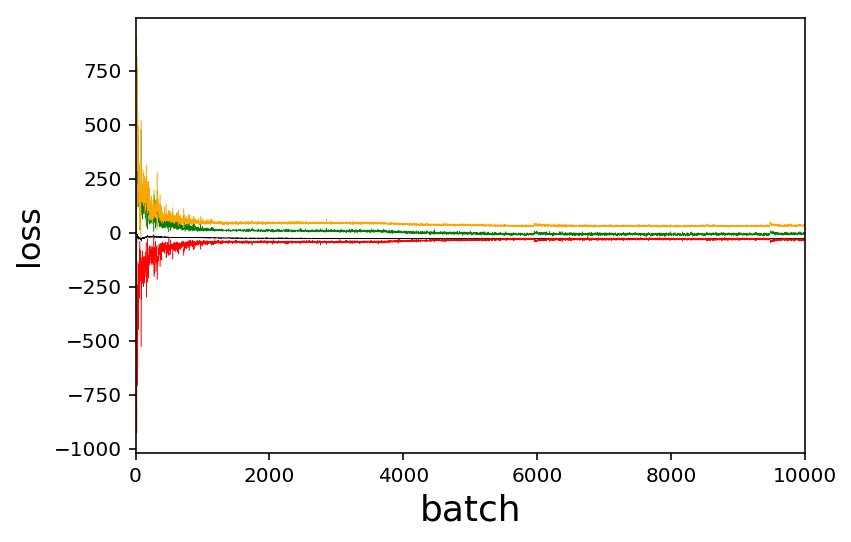

In [12]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, len(gan.d_losses))
# plt.ylim(0, 2)

plt.show()